# Experimento07: Redes Recurrentes LSTM

## Librerías

In [2]:
# Librerias necesarias
import os

# Matplotlib conf
import matplotlib.pyplot as plt
%matplotlib inline
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':40,
         'ytick.labelsize': 40
}
plt.rcParams.update(params)
# Seaborn conf
import seaborn as sns
sns.set(style='darkgrid')
sns.set_palette(sns.color_palette("Blues"))

import sys

#Procesado de datos
import pandas as pd
import numpy as np
import operator

#Modelos
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')


from sklearn.decomposition import TruncatedSVD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

from sklearn import preprocessing
from nltk import ngrams

from keras.layers import Dense, Embedding, Flatten, GlobalMaxPool1D, Dropout
from keras.models import Sequential, Model
from tensorflow.keras.layers import Input
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping

from tensorflow.keras import regularizers

from keras.initializers import Constant

from wordcloud import WordCloud

from sklearn.decomposition import TruncatedSVD
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import plot_model
import tensorflow as tf

from sklearn import preprocessing
from nltk import ngrams

from tensorflow.keras import regularizers

## Carga de conjunto de datos

In [3]:
df_training = pd.read_csv("./data/ds_training_processed.csv")
df_testing = pd.read_csv("./data/ds_testing_processed.csv")

X_train = df_training["text"]
y_train = df_training["sentiment"]
X_test = df_testing["text"]
y_test = df_testing["sentiment"]

y_train_2 = to_categorical(y_train, num_classes=2)
y_test_2 = to_categorical(y_test, num_classes=2)

## Carga de modelos de representación

In [4]:
def load_representation_model(file_name, include_embedding_matrix=False):
    res = {}
    with open("./repmodels/"+file_name+".txt", 'r') as d:
        res["model"] = d.readline()
    res["train_text_features"] = np.load("./repmodels/"+file_name+"_train.npy")
    res["test_text_features"] = np.load("./repmodels/"+file_name+"_test.npy")

    if include_embedding_matrix:
        res["embedding_matrix"] = np.load("./repmodels/"+file_name+"_embeddingmatrix.npy")

    return res

vsm_binary = load_representation_model("vsm_binary")
vsm_binary_ngrams = load_representation_model("vsm_binary_ngrams")
vsm_tfidf = load_representation_model("vsm_tfidf")
vsm_tfidf_ngrams = load_representation_model("vsm_tfidf_ngrams")
embedding_padding = load_representation_model("embedding_padding")
embedding_glove = load_representation_model("embedding_glove", include_embedding_matrix=True)

# Cargo esto por facilidad
vsm_model = []
vsm_model.append(vsm_binary)
vsm_model.append(vsm_binary_ngrams)
vsm_model.append(vsm_tfidf)
vsm_model.append(vsm_tfidf_ngrams)

## Funciones generales

In [5]:
pd.set_option('display.max_colwidth', 2000)
vocab_size = 29773
emb_dim = 50
num_words = 29773

results = []
def add_to_results(classifier, repmodel, predict_x, y_test):
    y_pred = np.argmax(predict_x,axis=1)

    results.append({"classifier": classifier,
                    "rep.model": repmodel,
                    "accuracy": accuracy_score(y_test, y_pred),
                    "precision": precision_score(y_test, y_pred, average="weighted"),
                    "recall": recall_score(y_test,y_pred, average="weighted")
                    })

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'bo', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.xlabel("Epochs")
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

def nn_classification_report(predict_x, y_test, class_names):
    y_pred = np.argmax(predict_x,axis=1)

    print("Classification Report")
    print

    print(classification_report(y_true=y_test, y_pred=y_pred, target_names=class_names))
    cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

    plot_confusion_matrix(cm, classes=class_names)

    print("Final Accuracy")
    print(accuracy_score(y_test, y_pred))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def join_csv_for_experiment(experiment_string, number_of_experiements):
    experiments_data = []
    for i in range(1, number_of_experiements+1):
        experiments_data.append( pd.read_csv("exp_"+experiment_string+"_"+str(i)+".csv") )

    res = pd.concat(experiments_data, ignore_index=True)
    res.to_csv("exp_"+experiment_string+".csv")

## Clasificadores

In [6]:
def build_exp07(
        name, 
        description, 
        rep, 
        input_shape,
        embedding=None,
        exp="Exp07", 
        layers_units=[64],
        extra_dense_layer_nn=0,
        extra_dense_dropout=0.0,
        dropout_layer=0.0,
        dropout=[0.0],
        recurrent_dropout=[0.0],
        make_it_bidirectional=False,
        kernel_regularizer=None
        ):
    callbacks = [
        keras.callbacks.EarlyStopping(
                monitor='val_loss',
                mode='min', 
                patience=7, 
                min_delta=0.01)        
    ]    
    inputs = keras.Input(shape=input_shape, dtype="float")

    return_sequences = False
    if len(layers_units)>1:
        return_sequences = True

    first_layer = layers.LSTM(layers_units[0], 
                              return_sequences=return_sequences,
                              dropout=dropout[0],
                              recurrent_dropout=recurrent_dropout[0], 
                              kernel_regularizer=kernel_regularizer)
    if make_it_bidirectional:
        first_layer = layers.Bidirectional(first_layer)

    if embedding:
        x = embedding(inputs)
        x = first_layer(x)
    else:
        x = first_layer(inputs)

    if return_sequences:
        layers_units.pop(0)
        for i, _ in enumerate(layers_units[:-1]):
            new_layer = layers.LSTM(layers_units[i], 
                                    return_sequences=True,
                                    dropout=dropout[i],
                                    recurrent_dropout=recurrent_dropout[i], 
                                    kernel_regularizer=kernel_regularizer)
            if make_it_bidirectional:
                new_layer = layers.Bidirectional(new_layer)
            x = new_layer(x)
        last_layer = layers.LSTM(layers_units[-1], 
                                 return_sequences=False, 
                                 dropout=dropout[-1],
                                 recurrent_dropout=recurrent_dropout[-1], 
                                 kernel_regularizer=kernel_regularizer)
        new_layer = last_layer
        if make_it_bidirectional:
            new_layer = layers.Bidirectional(last_layer)        
        x = new_layer(x)

    if dropout_layer > 0:
        x = layers.Dropout(dropout_layer)(x)

    if extra_dense_layer_nn > 0:
        x = layers.Dense(extra_dense_layer_nn, activation="relu")(x)
        if extra_dense_dropout > 0:
            x = layers.Dropout(extra_dense_dropout)(x)
    
    outputs = layers.Dense(2, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model._name = exp+name
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    print(model.summary())
    history = model.fit(rep["train_text_features"].astype(float), 
                        y_train_2, 
                        epochs=40,
                        batch_size=32,
                        validation_split=0.2, 
                        callbacks=callbacks)
    plot_history(history)
    predict_x=model.predict(rep["test_text_features"].astype(float))
    nn_classification_report(predict_x, y_test, ["negative", "positive"])
    add_to_results(model._name+" "+description, rep["model"], predict_x, y_test)

2024-04-28 19:48:21.379439: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-28 19:48:21.432303: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-28 19:48:21.432532: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "Exp07LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 600)]             0         
                                                                 
 embedding (Embedding)       (None, 600, 50)           1488650   
                                                                 
 lstm (LSTM)                 (None, 600, 16)           4288      
                                                                 
 lstm_1 (LSTM)               (None, 32)                6272      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 2)                 66        
                                                                 
Total params: 1499276 (5.72 MB)
Trainable params: 1499276

2024-04-28 19:48:24.211613: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-28 19:48:24.516165: I external/local_xla/xla/service/service.cc:168] XLA service 0x70e76c7694c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-28 19:48:24.516202: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-04-28 19:48:24.524818: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1714326504.601541  464178 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 [==============================] - 36s 133ms/step - loss: 0.4204 - accuracy: 0.8115 - val_loss: 0.4189 - val_accuracy: 0.8099
Epoch 2/40
250/250 [==============================] - 27s 106ms/step - loss: 0.2682 - accuracy: 0.9086 - val_loss: 0.4682 - val_accuracy: 0.8364
Epoch 3/40
250/250 [==============================] - 24s 95ms/step - loss: 0.1261 - accuracy: 0.9577 - val_loss: 0.4169 - val_accuracy: 0.8339
Epoch 4/40
250/250 [==============================] - 22s 88ms/step - loss: 0.0779 - accuracy: 0.9744 - val_loss: 0.5358 - val_accuracy: 0.8379
Epoch 5/40
250/250 [==============================] - 20s 81ms/step - loss: 0.0537 - accuracy: 0.9831 - val_loss: 0.6578 - val_accuracy: 0.8234
Epoch 6/40
250/250 [==============================] - 18s 72ms/step - loss: 0.0432 - accuracy: 0.9862 - val_loss: 0.4892 - val_accuracy: 0.8644
Epoch 7/40
250/250 [==============================] - 16s 63ms/step - loss: 0.0352 - accuracy: 0.9891 - val_loss: 0.4675 - val_accuracy: 0.8814
E

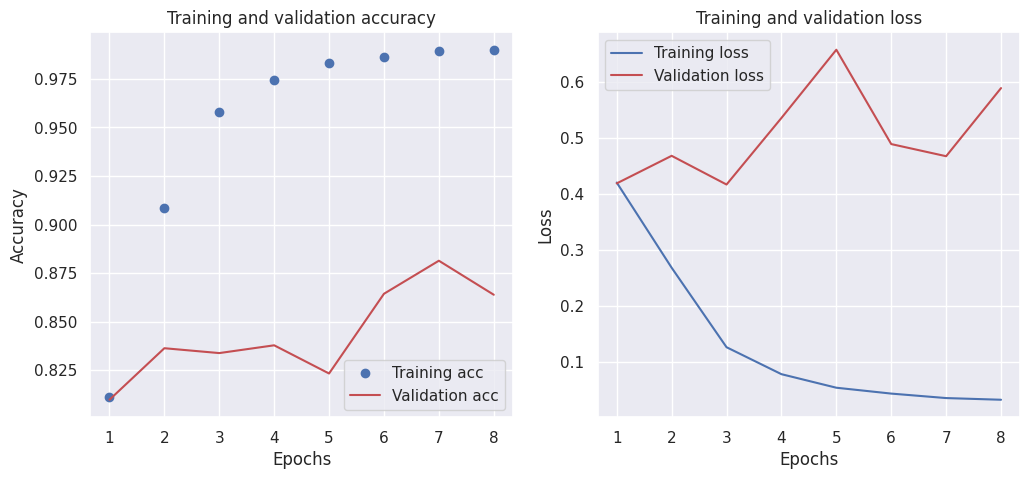

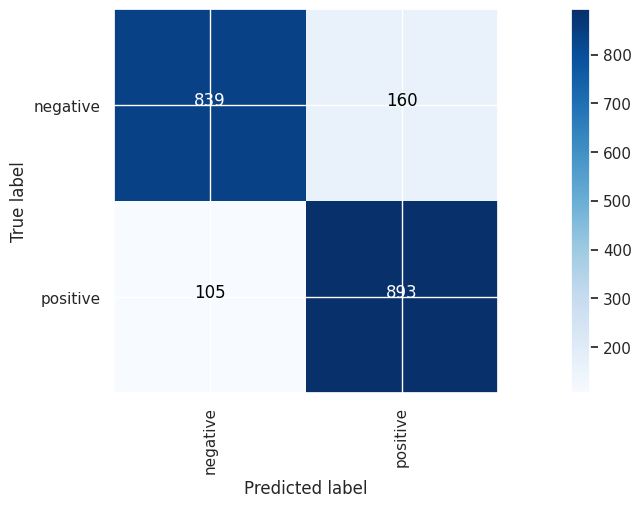

Final Accuracy
0.8673009514271407
Model: "Exp07LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 600)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 600, 50)           1488650   
                                                                 
 lstm_2 (LSTM)               (None, 32)                10624     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
Total params: 1499340 (5.72 MB)
Trainable params: 1499340 (5.72 MB)
Non-trainable params: 0 (0.00 Byte)
___________________________________________________

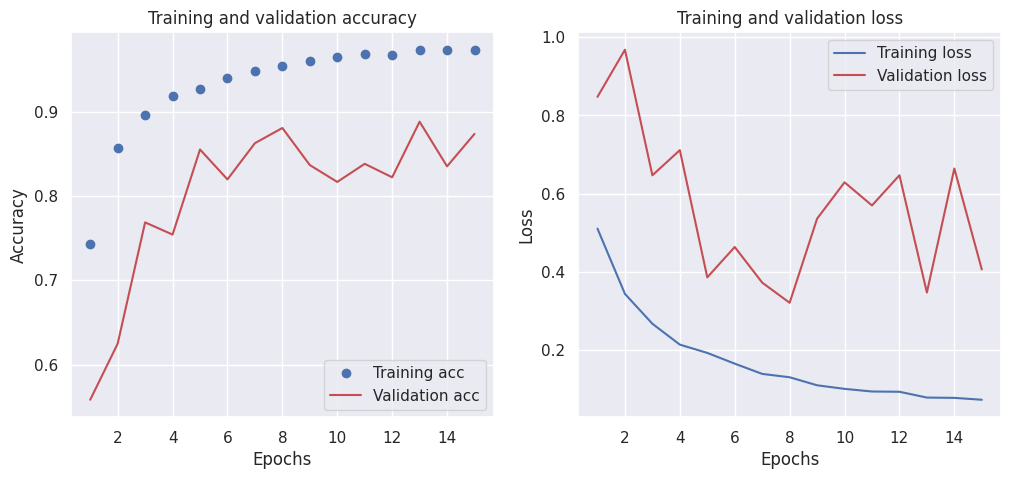

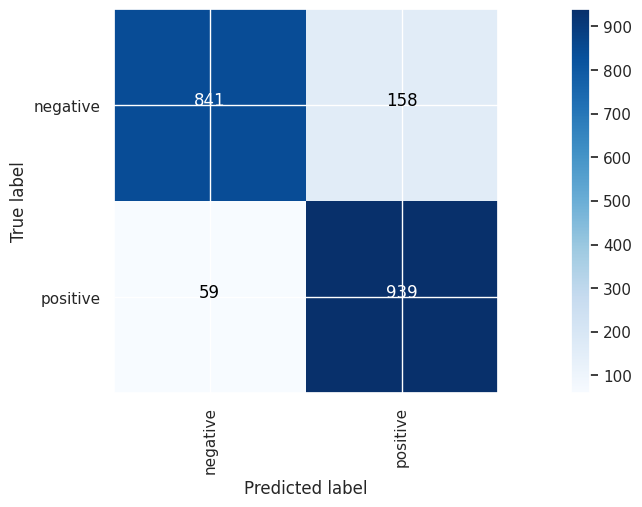

Final Accuracy
0.8913370055082624


In [9]:
results = []
name = "LSTM"
description =   """
                layers_units=[16,32],
                extra_dense_layer_nn=0,
                extra_dense_dropout=0.0,
                dropout_layer=0.2,
                dropout=[0.4,0.4],
                recurrent_dropout=[0.0,0.0],
                make_it_bidirectional=False,
                kernel_regularizer=None
                """
description = description.replace('\t', '').replace('\n', '').replace(' ', '')

layers_units=[16,32]
extra_dense_layer_nn=0
extra_dense_dropout=0.0
dropout_layer=0.2
dropout=[0.4,0.4]
recurrent_dropout=[0.0,0.0]
make_it_bidirectional=False
kernel_regularizer=None

# Embedding with padding
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp07(name,
            description, 
            embedding_padding, 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout=extra_dense_dropout,
            dropout_layer=dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer          
            )

# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp07(name,
            description, 
            embedding_glove, 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout=extra_dense_dropout,
            dropout_layer=dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer       
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_07_1.csv", index=False)

Model: "Exp07LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 600)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 600, 50)           1488650   
                                                                 
 lstm_3 (LSTM)               (None, 600, 16)           4288      
                                                                 
 lstm_4 (LSTM)               (None, 32)                6272      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 1499276 (5.72 MB)
Trainable params: 1499276

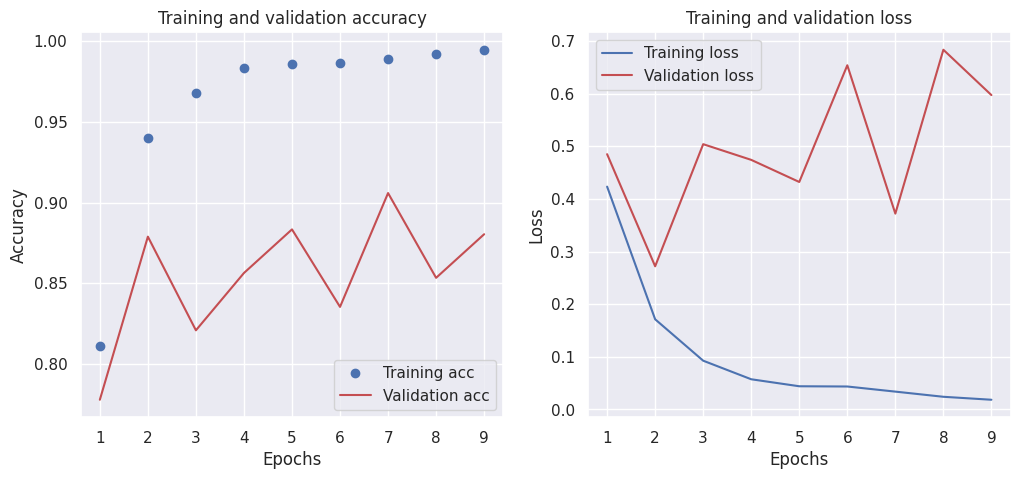

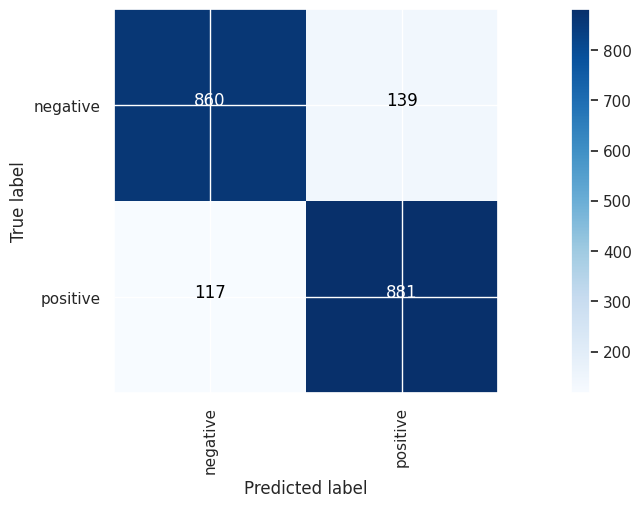

Final Accuracy
0.871807711567351
Model: "Exp07LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 600)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 600, 50)           1488650   
                                                                 
 lstm_5 (LSTM)               (None, 32)                10624     
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 66        
                                                                 
Total params: 1499340 (5.72 MB)
Trainable params: 1499340 (5.72 MB)
Non-trainable params: 0 (0.00 Byte)
____________________________________________________

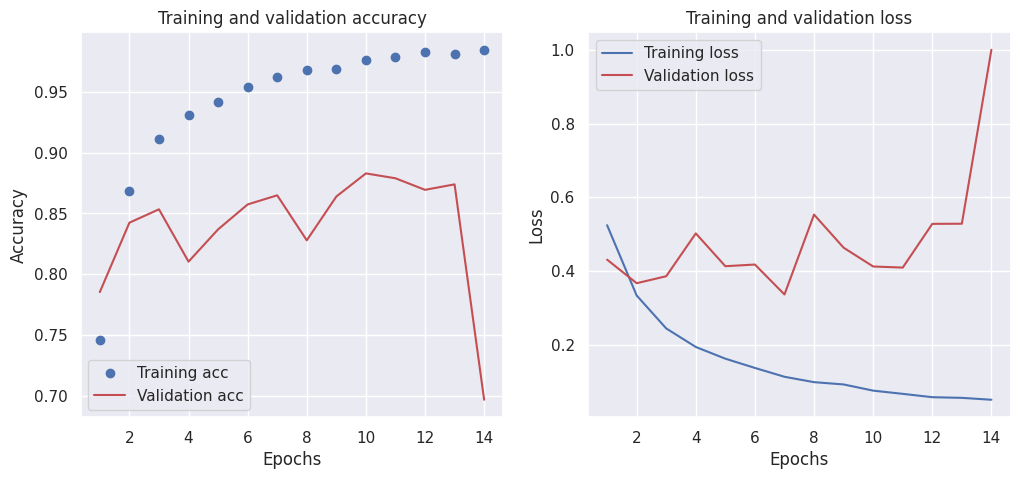

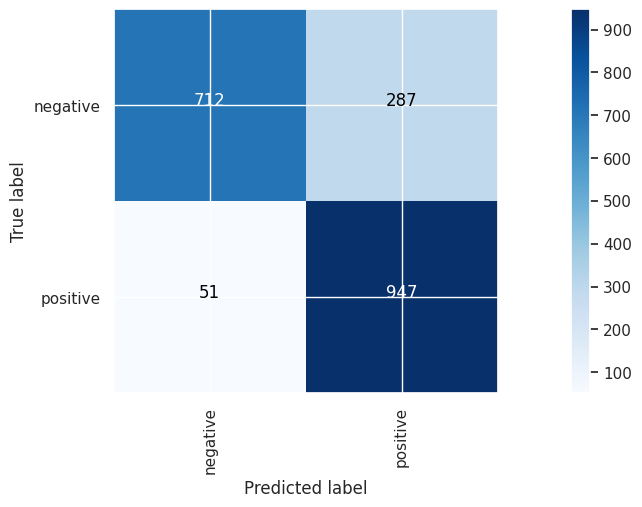

Final Accuracy
0.8307461191787682


In [10]:
results = []
name = "LSTM"
description =   """
                layers_units=[16,32],
                extra_dense_layer_nn=0,
                extra_dense_dropout=0.0,
                dropout_layer=0.5,
                dropout=[0.2,0.2],
                recurrent_dropout=[0.0,0.0],
                make_it_bidirectional=False,
                kernel_regularizer=None
                """
description = description.replace('\t', '').replace('\n', '').replace(' ', '')

layers_units=[16,32]
extra_dense_layer_nn=0
extra_dense_dropout=0.0
dropout_layer=0.5
dropout=[0.2,0.2]
recurrent_dropout=[0.0,0.0]
make_it_bidirectional=False
kernel_regularizer=None

# Embedding with padding
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp07(name,
            description, 
            embedding_padding, 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout=extra_dense_dropout,
            dropout_layer=dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer          
            )

# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp07(name,
            description, 
            embedding_glove, 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout=extra_dense_dropout,
            dropout_layer=dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer       
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_07_2.csv", index=False)

Model: "Exp07LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 600)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 600, 50)           1488650   
                                                                 
 lstm_6 (LSTM)               (None, 600, 16)           4288      
                                                                 
 lstm_7 (LSTM)               (None, 32)                6272      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 2)                 66        
                                                                 
Total params: 1499276 (5.72 MB)
Trainable params: 1499276

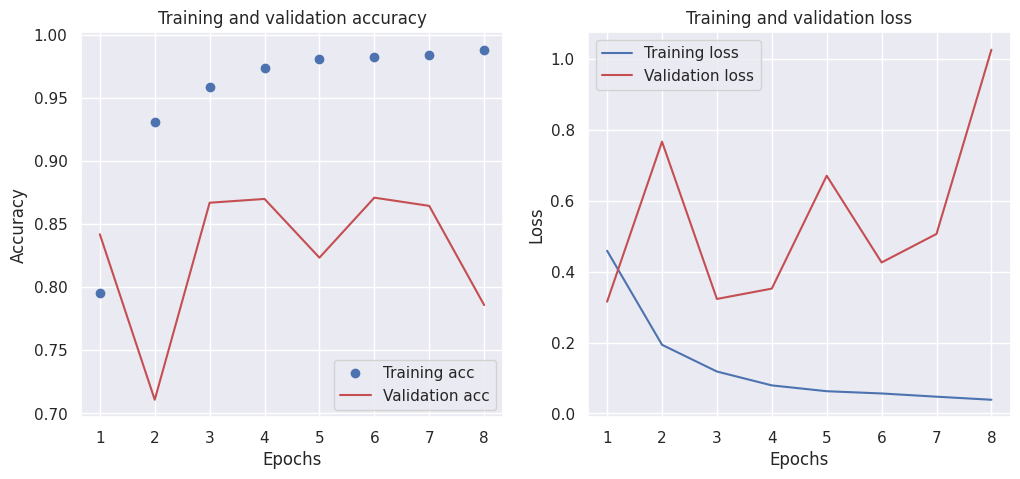

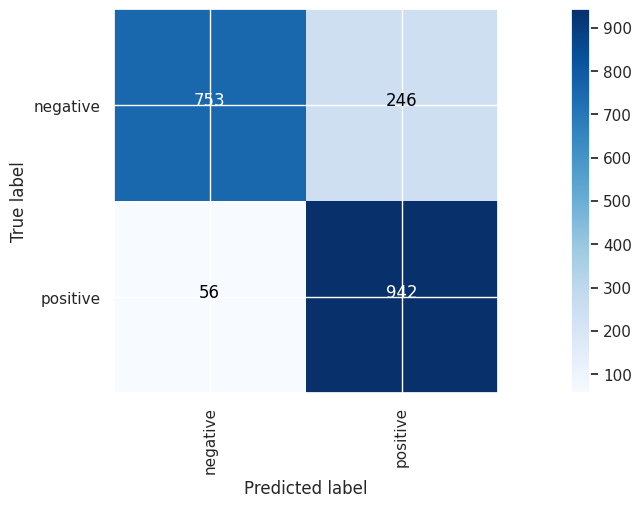

Final Accuracy
0.8487731597396094
Model: "Exp07LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 600)]             0         
                                                                 
 embedding_5 (Embedding)     (None, 600, 50)           1488650   
                                                                 
 lstm_8 (LSTM)               (None, 32)                10624     
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 2)                 66        
                                                                 
Total params: 1499340 (5.72 MB)
Trainable params: 1499340 (5.72 MB)
Non-trainable params: 0 (0.00 Byte)
___________________________________________________

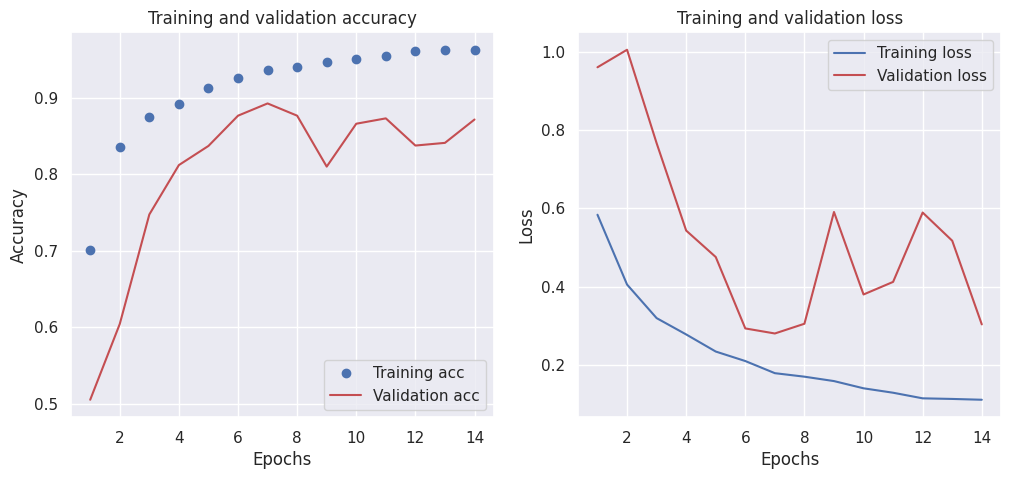

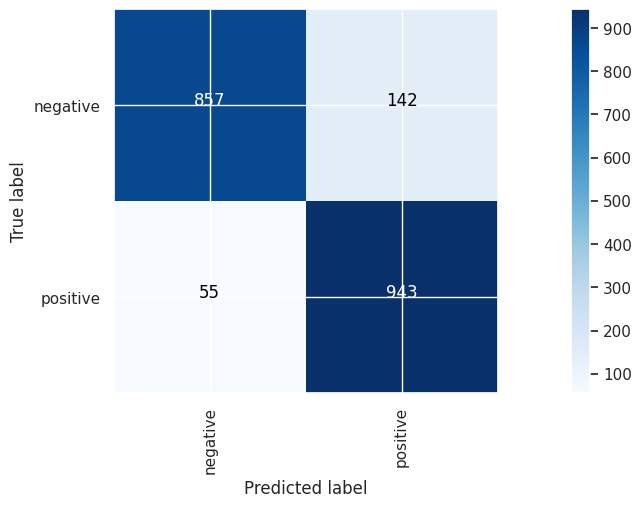

Final Accuracy
0.901352028042063


In [11]:
results = []
name = "LSTM"
description =   """
                layers_units=[16,32],
                extra_dense_layer_nn=0,
                extra_dense_dropout=0.0,
                dropout_layer=0.5,
                dropout=[0.5,0.5],
                recurrent_dropout=[0.0,0.0],
                make_it_bidirectional=False,
                kernel_regularizer=None
                """
description = description.replace('\t', '').replace('\n', '').replace(' ', '')

layers_units=[16,32]
extra_dense_layer_nn=0
extra_dense_dropout=0.0
dropout_layer=0.5
dropout=[0.5,0.5]
recurrent_dropout=[0.0,0.0]
make_it_bidirectional=False
kernel_regularizer=None

# Embedding with padding
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp07(name,
            description, 
            embedding_padding, 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout=extra_dense_dropout,
            dropout_layer=dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer          
            )

# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp07(name,
            description, 
            embedding_glove, 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout=extra_dense_dropout,
            dropout_layer=dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer       
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_07_3.csv", index=False)

Model: "Exp07LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 600)]             0         
                                                                 
 embedding_6 (Embedding)     (None, 600, 50)           1488650   
                                                                 
 bidirectional (Bidirection  (None, 600, 32)           8576      
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                16640     
 onal)                                                           
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 2)                 13

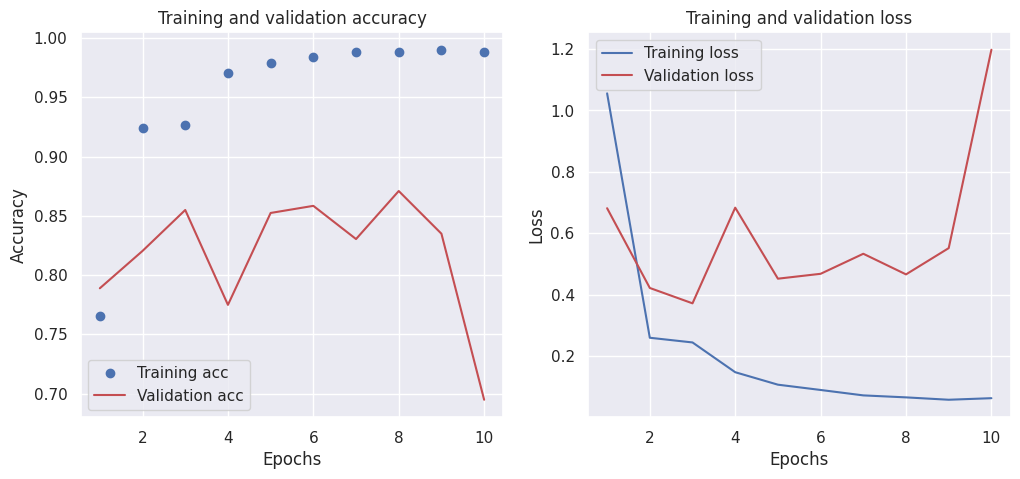

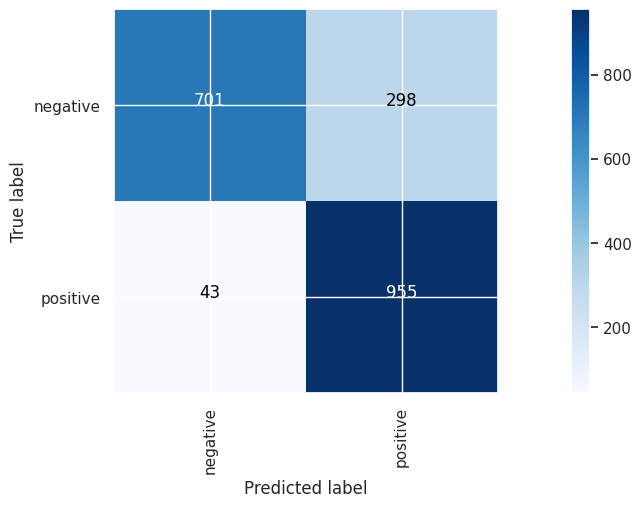

Final Accuracy
0.829243865798698
Model: "Exp07LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 600)]             0         
                                                                 
 embedding_7 (Embedding)     (None, 600, 50)           1488650   
                                                                 
 bidirectional_2 (Bidirecti  (None, 64)                21248     
 onal)                                                           
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 2)                 130       
                                                                 
Total params: 1510028 (5.76 MB)
Trainable params: 1510028 (5.76 MB)
Non-trainable params: 

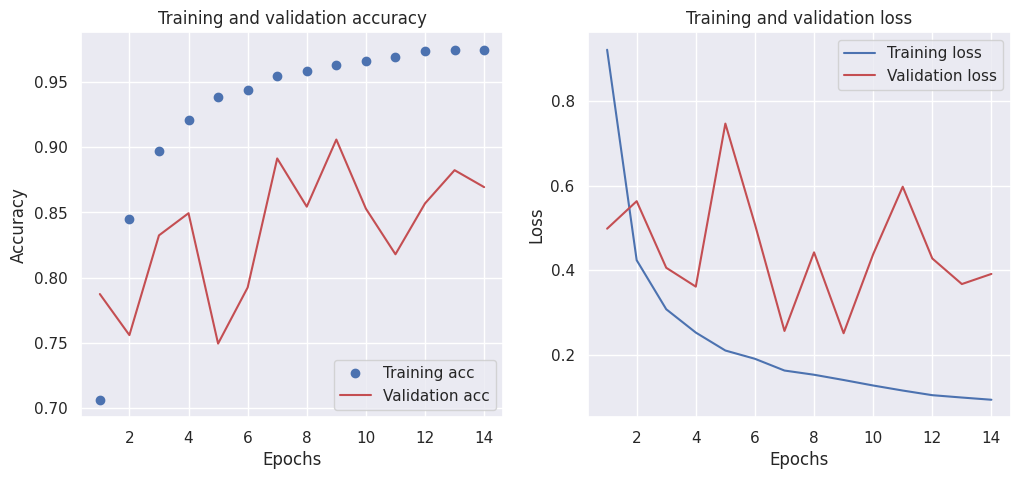

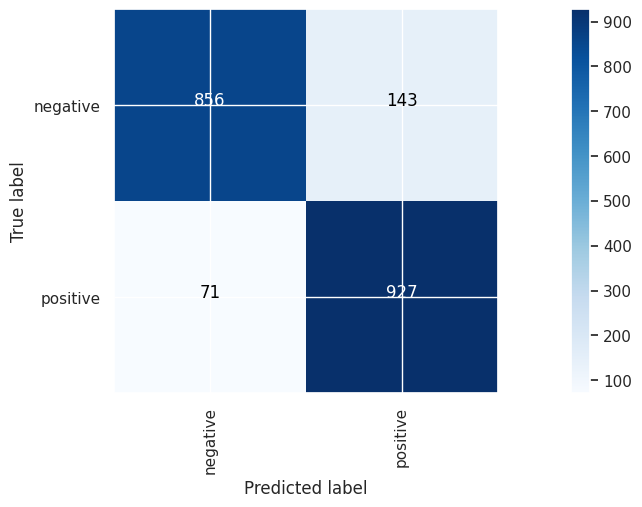

Final Accuracy
0.8928392588883325


In [12]:
results = []
name = "LSTM"
description =   """
                layers_units=[16,32],
                extra_dense_layer_nn=0,
                extra_dense_dropout=0.0,
                dropout_layer=0.5,
                dropout=[0.5,0.5],
                recurrent_dropout=[0.0,0.0],
                make_it_bidirectional=True,
                kernel_regularizer=regularizers.l2(0.01)
                """
description = description.replace('\t', '').replace('\n', '').replace(' ', '')

layers_units=[16,32]
extra_dense_layer_nn=0
extra_dense_dropout=0.0
dropout_layer=0.5
dropout=[0.3,0.3]
recurrent_dropout=[0.0,0.0]
make_it_bidirectional=True
kernel_regularizer=kernel_regularizer=regularizers.l2(0.01)

# Embedding with padding
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp07(name,
            description, 
            embedding_padding, 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout=extra_dense_dropout,
            dropout_layer=dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer          
            )

# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp07(name,
            description, 
            embedding_glove, 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout=extra_dense_dropout,
            dropout_layer=dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer       
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_07_4.csv", index=False)

Model: "Exp07LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 600)]             0         
                                                                 
 embedding_9 (Embedding)     (None, 600, 50)           1488650   
                                                                 
 bidirectional_4 (Bidirecti  (None, 32)                8576      
 onal)                                                           
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 2)                 66        
                                                                 
Total params: 1497292 (5.71 MB)
Trainable params: 1497292 (5.71 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

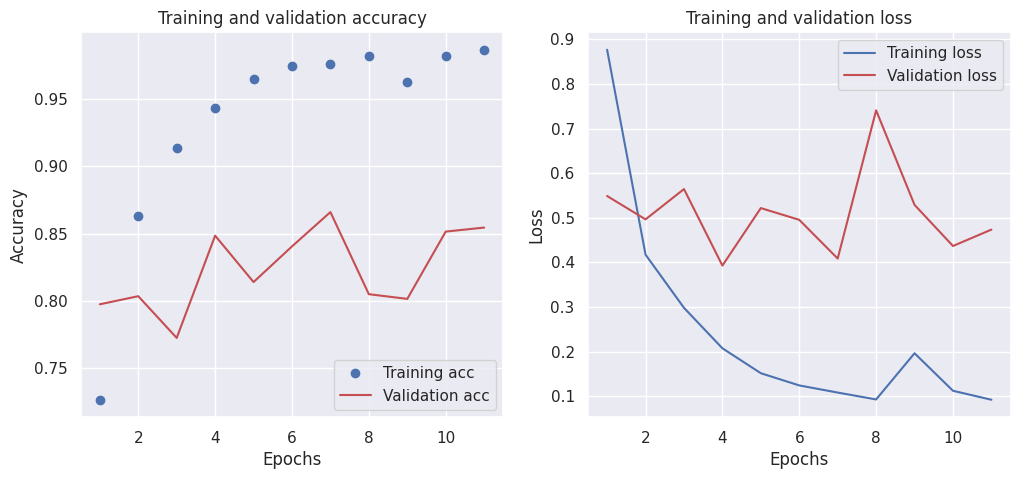

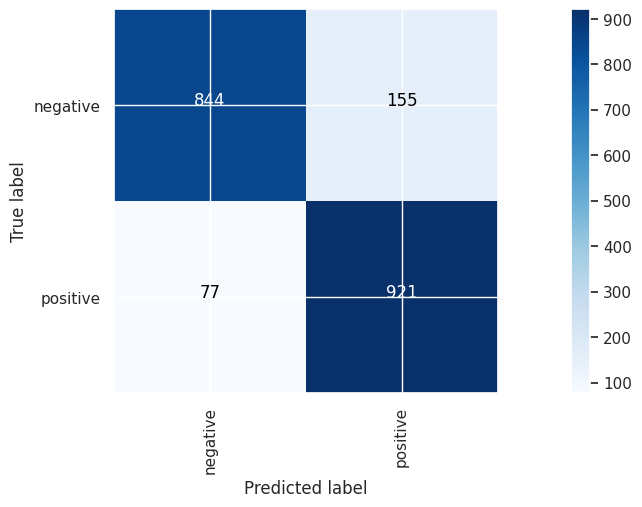

Final Accuracy
0.8838257386079119
Model: "Exp07LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 600)]             0         
                                                                 
 embedding_10 (Embedding)    (None, 600, 50)           1488650   
                                                                 
 bidirectional_5 (Bidirecti  (None, 32)                8576      
 onal)                                                           
                                                                 
 dropout_10 (Dropout)        (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 2)                 66        
                                                                 
Total params: 1497292 (5.71 MB)
Trainable params: 1497292 (5.71 MB)
Non-trainable params:

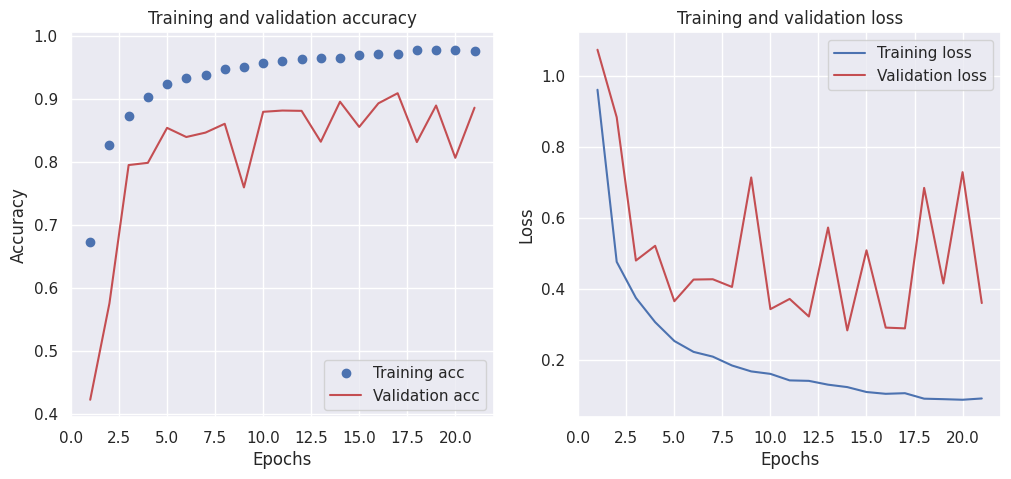

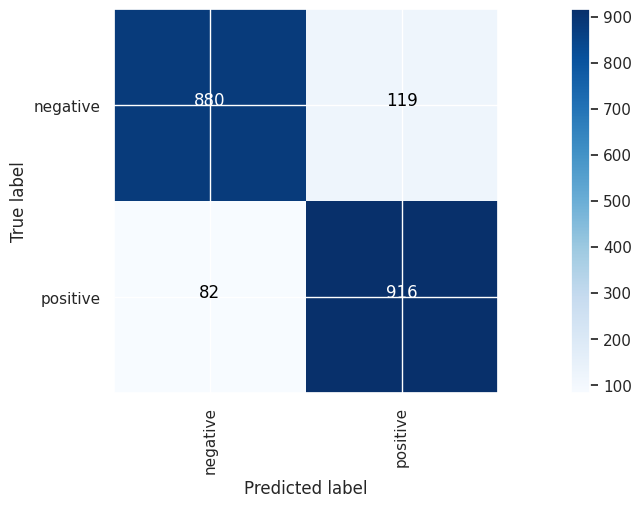

Final Accuracy
0.899349023535303


In [14]:
results = []
name = "LSTM"
description =   """
                layers_units=[16],
                extra_dense_layer_nn=0,
                extra_dense_dropout=0.0,
                dropout_layer=0.5,
                dropout=[0.5],
                recurrent_dropout=[0.0],
                make_it_bidirectional=True,
                kernel_regularizer=regularizers.l2(0.01)
                """
description = description.replace('\t', '').replace('\n', '').replace(' ', '')

layers_units=[16]
extra_dense_layer_nn=0
extra_dense_dropout=0.0
dropout_layer=0.5
dropout=[0.4]
recurrent_dropout=[0.0]
make_it_bidirectional=True
kernel_regularizer=kernel_regularizer=regularizers.l2(0.01)

# Embedding with padding
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp07(name,
            description, 
            embedding_padding, 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout=extra_dense_dropout,
            dropout_layer=dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer          
            )

# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp07(name,
            description, 
            embedding_glove, 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout=extra_dense_dropout,
            dropout_layer=dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer       
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_07_5.csv", index=False)

Model: "Exp07LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 600)]             0         
                                                                 
 embedding_11 (Embedding)    (None, 600, 50)           1488650   
                                                                 
 bidirectional_6 (Bidirecti  (None, 32)                8576      
 onal)                                                           
                                                                 
 dense_11 (Dense)            (None, 2)                 66        
                                                                 
Total params: 1497292 (5.71 MB)
Trainable params: 1497292 (5.71 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/40
250/250 [==============================] - 29s 111ms/step - loss: 0.8

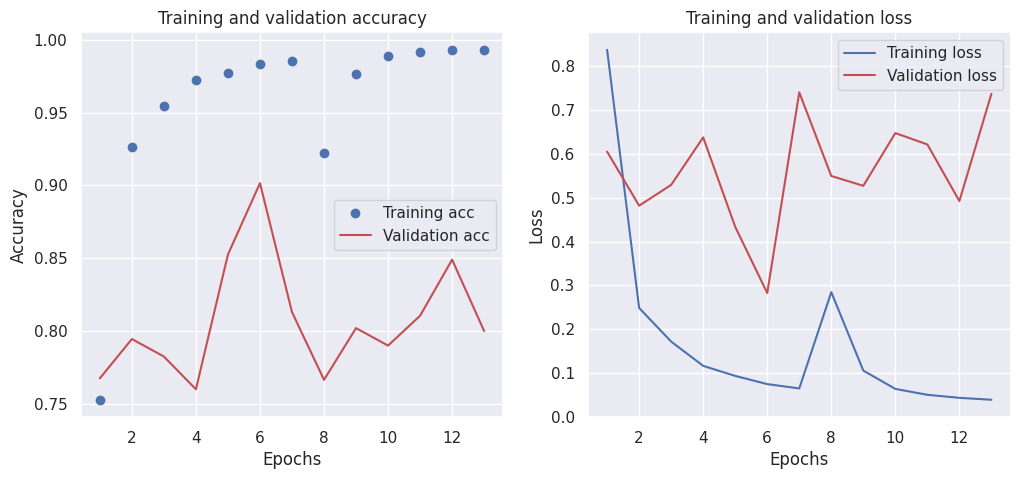

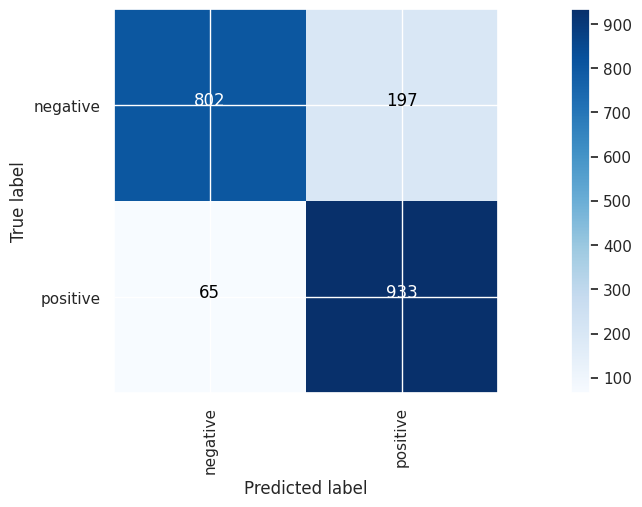

Final Accuracy
0.8688032048072108
Model: "Exp07LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 600)]             0         
                                                                 
 embedding_12 (Embedding)    (None, 600, 50)           1488650   
                                                                 
 bidirectional_7 (Bidirecti  (None, 32)                8576      
 onal)                                                           
                                                                 
 dense_12 (Dense)            (None, 2)                 66        
                                                                 
Total params: 1497292 (5.71 MB)
Trainable params: 1497292 (5.71 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/40
250/250 [==========================

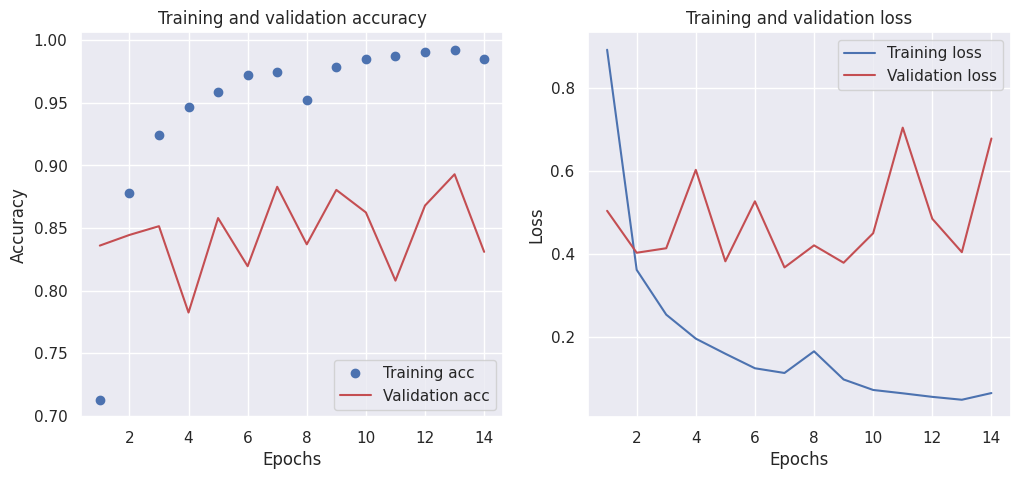

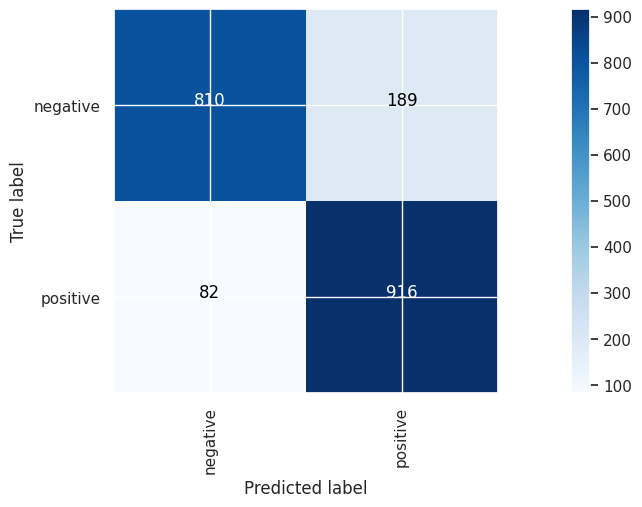

Final Accuracy
0.8642964446670005


In [15]:
results = []
name = "LSTM"
description =   """
                layers_units=[16],
                extra_dense_layer_nn=0,
                extra_dense_dropout=0.0,
                dropout_layer=0.0,
                dropout=[0.0],
                recurrent_dropout=[0.0],
                make_it_bidirectional=True,
                kernel_regularizer=regularizers.l2(0.01)
                """
description = description.replace('\t', '').replace('\n', '').replace(' ', '')

layers_units=[16]
extra_dense_layer_nn=0
extra_dense_dropout=0.0
dropout_layer=0.0
dropout=[0.0]
recurrent_dropout=[0.0]
make_it_bidirectional=True
kernel_regularizer=kernel_regularizer=regularizers.l2(0.01)

# Embedding with padding
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp07(name,
            description, 
            embedding_padding, 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout=extra_dense_dropout,
            dropout_layer=dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer          
            )

# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp07(name,
            description, 
            embedding_glove, 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout=extra_dense_dropout,
            dropout_layer=dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer       
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_07_6.csv", index=False)

Model: "Exp07LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 600)]             0         
                                                                 
 embedding_13 (Embedding)    (None, 600, 50)           1488650   
                                                                 
 lstm_17 (LSTM)              (None, 16)                4288      
                                                                 
 dense_13 (Dense)            (None, 2)                 34        
                                                                 
Total params: 1492972 (5.70 MB)
Trainable params: 1492972 (5.70 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/40
250/250 [==============================] - 23s 89ms/step - loss: 0.6613 - accuracy: 0.7581 - val_loss: 0.6350 - val_accuracy: 0.7469
Ep

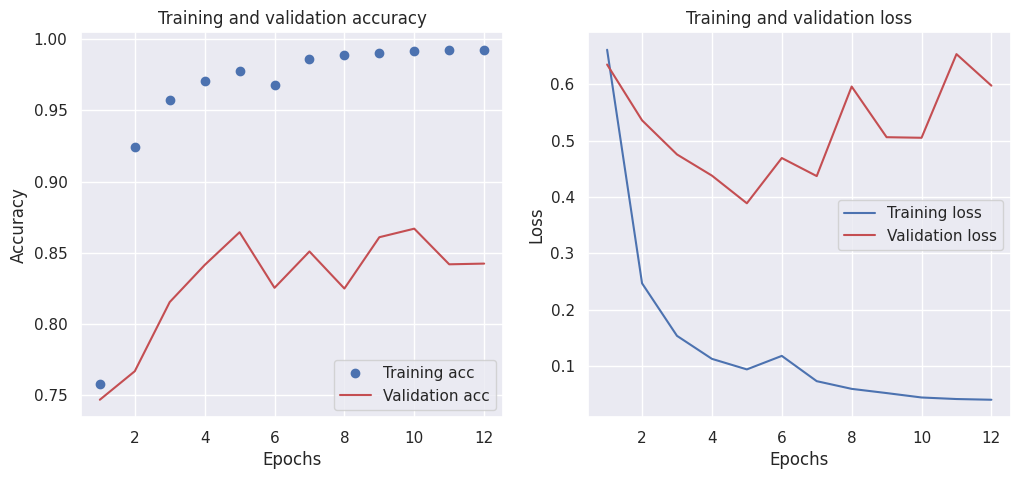

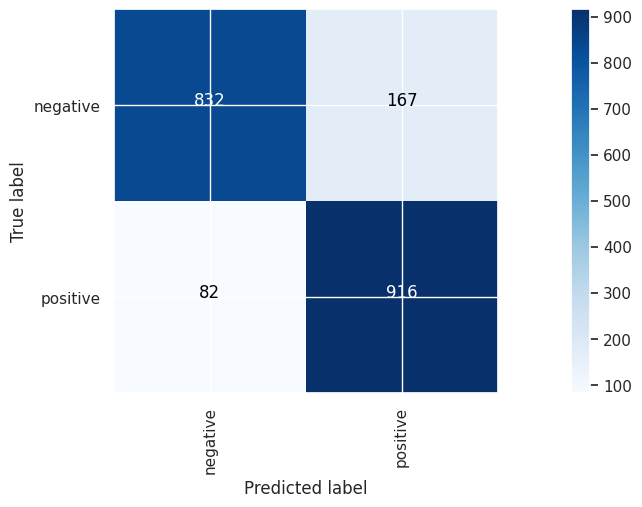

Final Accuracy
0.8753129694541812
Model: "Exp07LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 600)]             0         
                                                                 
 embedding_14 (Embedding)    (None, 600, 50)           1488650   
                                                                 
 lstm_18 (LSTM)              (None, 16)                4288      
                                                                 
 dense_14 (Dense)            (None, 2)                 34        
                                                                 
Total params: 1492972 (5.70 MB)
Trainable params: 1492972 (5.70 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/40
250/250 [==============================] - 23s 88ms/step - loss: 0.7093 - accuracy: 0.7583 - val_loss

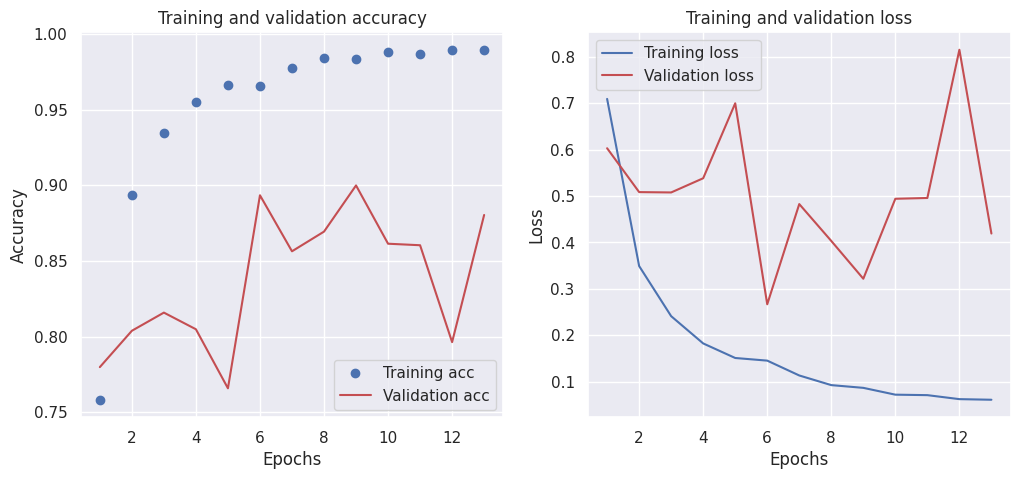

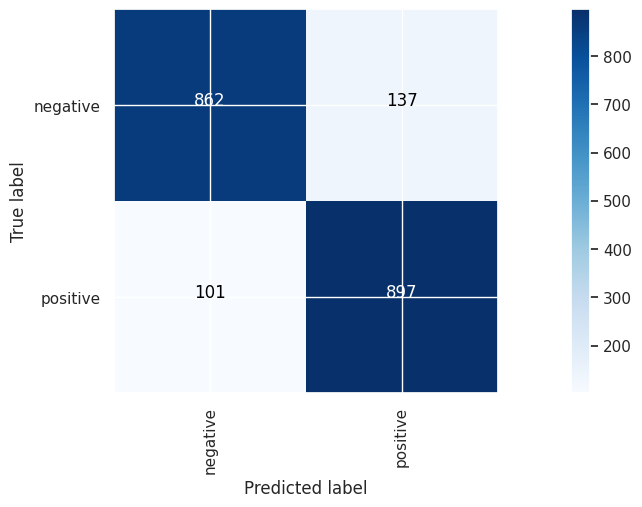

Final Accuracy
0.8808212318477716


In [16]:
results = []
name = "LSTM"
description =   """
                layers_units=[16],
                extra_dense_layer_nn=0,
                extra_dense_dropout=0.0,
                dropout_layer=0.0,
                dropout=[0.0],
                recurrent_dropout=[0.0],
                make_it_bidirectional=False,
                kernel_regularizer=regularizers.l2(0.01)
                """
description = description.replace('\t', '').replace('\n', '').replace(' ', '')

layers_units=[16]
extra_dense_layer_nn=0
extra_dense_dropout=0.0
dropout_layer=0.0
dropout=[0.0]
recurrent_dropout=[0.0]
make_it_bidirectional=False
kernel_regularizer=kernel_regularizer=regularizers.l2(0.01)

# Embedding with padding
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp07(name,
            description, 
            embedding_padding, 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout=extra_dense_dropout,
            dropout_layer=dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer          
            )

# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp07(name,
            description, 
            embedding_glove, 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout=extra_dense_dropout,
            dropout_layer=dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer       
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_07_7.csv", index=False)

Model: "Exp07LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 600)]             0         
                                                                 
 embedding_15 (Embedding)    (None, 600, 50)           1488650   
                                                                 
 lstm_19 (LSTM)              (None, 1)                 208       
                                                                 
 dense_15 (Dense)            (None, 2)                 4         
                                                                 
Total params: 1488862 (5.68 MB)
Trainable params: 1488862 (5.68 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/40
250/250 [==============================] - 22s 83ms/step - loss: 0.6954 - accuracy: 0.6238 - val_loss: 0.8326 - val_accuracy: 0.0015
Ep

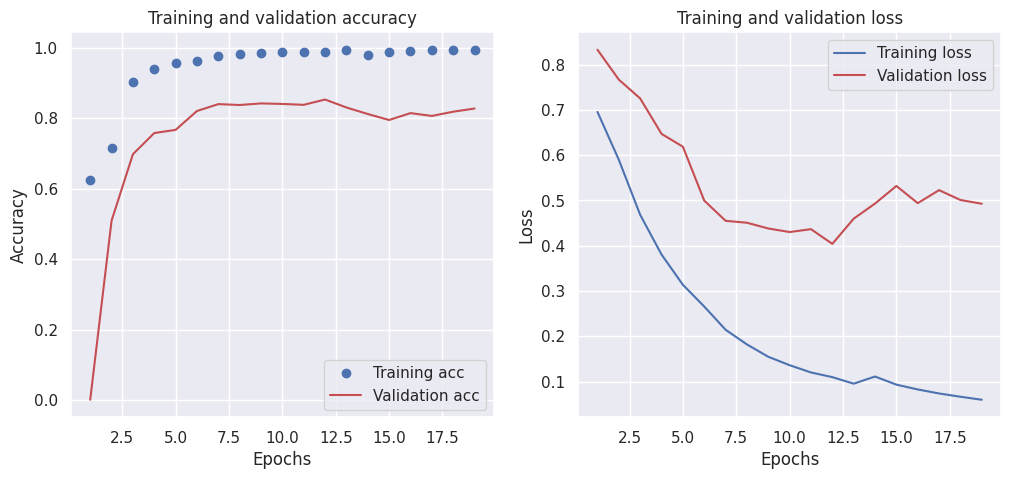

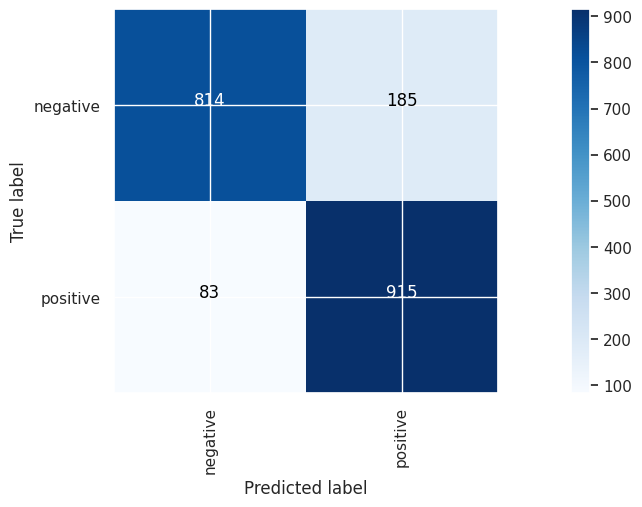

Final Accuracy
0.8657986980470707
Model: "Exp07LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 600)]             0         
                                                                 
 embedding_16 (Embedding)    (None, 600, 50)           1488650   
                                                                 
 lstm_20 (LSTM)              (None, 1)                 208       
                                                                 
 dense_16 (Dense)            (None, 2)                 4         
                                                                 
Total params: 1488862 (5.68 MB)
Trainable params: 1488862 (5.68 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/40
250/250 [==============================] - 22s 84ms/step - loss: 0.7022 - accuracy: 0.6243 - val_loss

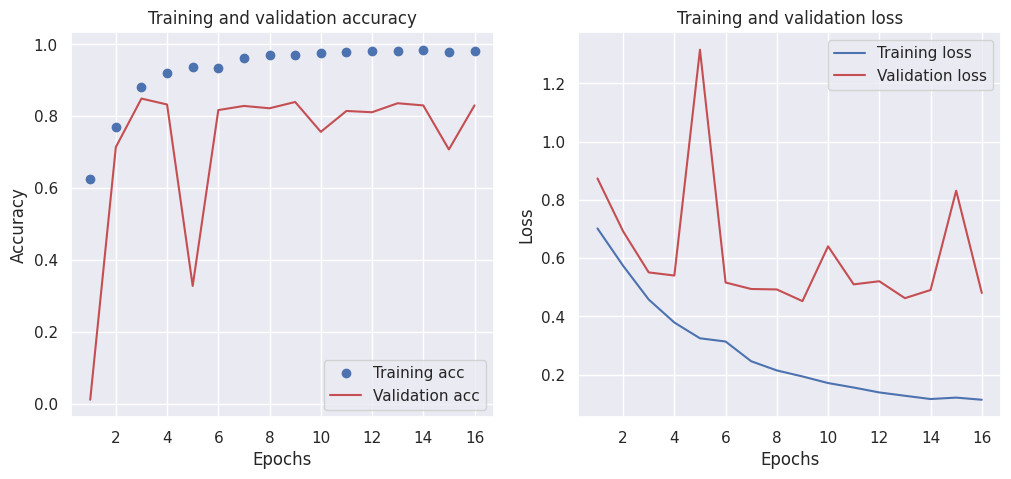

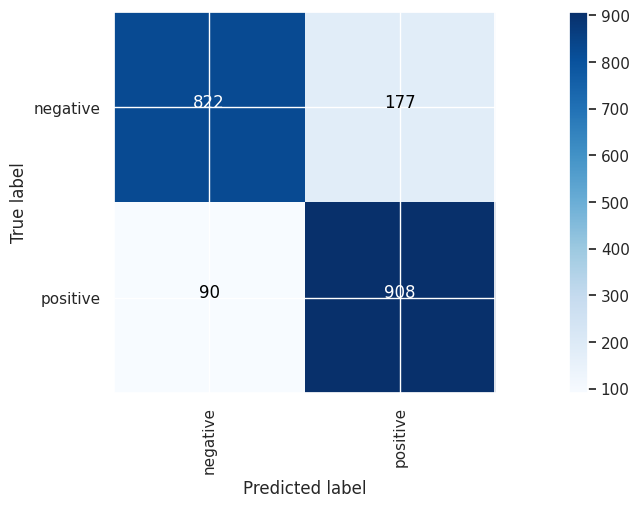

Final Accuracy
0.8662994491737607


In [17]:
results = []
name = "LSTM"
description =   """
                layers_units=[1],
                extra_dense_layer_nn=0,
                extra_dense_dropout=0.0,
                dropout_layer=0.0,
                dropout=[0.0],
                recurrent_dropout=[0.0],
                make_it_bidirectional=False,
                kernel_regularizer=regularizers.l2(0.01)
                """
description = description.replace('\t', '').replace('\n', '').replace(' ', '')

layers_units=[1]
extra_dense_layer_nn=0
extra_dense_dropout=0.0
dropout_layer=0.0
dropout=[0.0]
recurrent_dropout=[0.0]
make_it_bidirectional=False
kernel_regularizer=kernel_regularizer=regularizers.l2(0.01)

# Embedding with padding
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp07(name,
            description, 
            embedding_padding, 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout=extra_dense_dropout,
            dropout_layer=dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer          
            )

# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp07(name,
            description, 
            embedding_glove, 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout=extra_dense_dropout,
            dropout_layer=dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer       
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_07_8.csv", index=False)

Model: "Exp07LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 600)]             0         
                                                                 
 embedding_17 (Embedding)    (None, 600, 50)           1488650   
                                                                 
 lstm_21 (LSTM)              (None, 1)                 208       
                                                                 
 dropout_11 (Dropout)        (None, 1)                 0         
                                                                 
 dense_17 (Dense)            (None, 2)                 4         
                                                                 
Total params: 1488862 (5.68 MB)
Trainable params: 1488862 (5.68 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/40
250

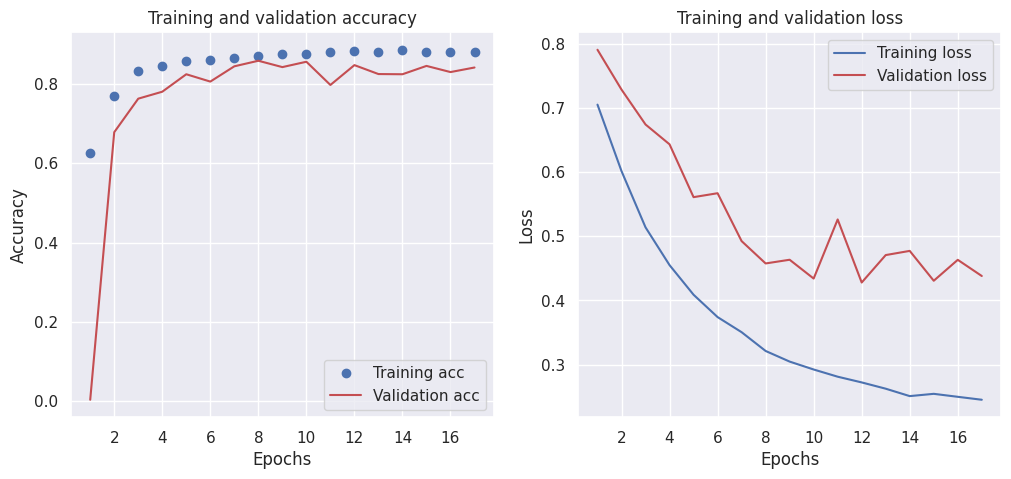

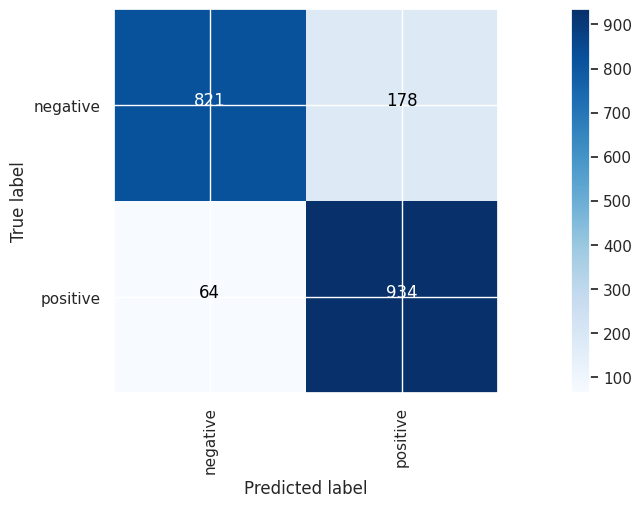

Final Accuracy
0.8788182273410116
Model: "Exp07LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 600)]             0         
                                                                 
 embedding_18 (Embedding)    (None, 600, 50)           1488650   
                                                                 
 lstm_22 (LSTM)              (None, 1)                 208       
                                                                 
 dropout_12 (Dropout)        (None, 1)                 0         
                                                                 
 dense_18 (Dense)            (None, 2)                 4         
                                                                 
Total params: 1488862 (5.68 MB)
Trainable params: 1488862 (5.68 MB)
Non-trainable params: 0 (0.00 Byte)
___________________________________________________

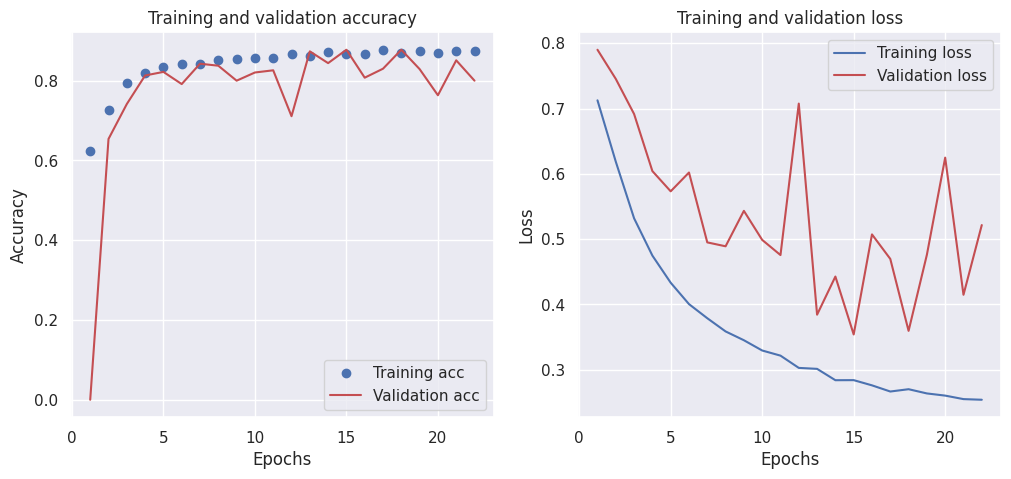

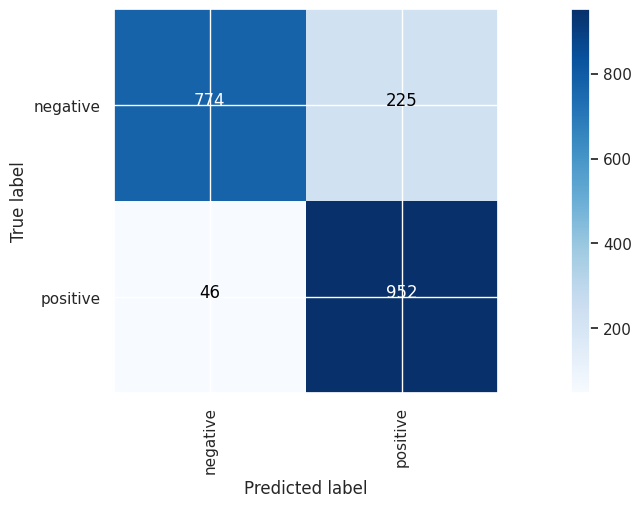

Final Accuracy
0.8642964446670005


In [18]:
results = []
name = "LSTM"
description =   """
                layers_units=[1],
                extra_dense_layer_nn=0,
                extra_dense_dropout=0.0,
                dropout_layer=0.3,
                dropout=[0.25],
                recurrent_dropout=[0.0],
                make_it_bidirectional=False,
                kernel_regularizer=regularizers.l2(0.01)
                """
description = description.replace('\t', '').replace('\n', '').replace(' ', '')

layers_units=[1]
extra_dense_layer_nn=0
extra_dense_dropout=0.0
dropout_layer=0.3
dropout=[0.25]
recurrent_dropout=[0.0]
make_it_bidirectional=False
kernel_regularizer=kernel_regularizer=regularizers.l2(0.01)

# Embedding with padding
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp07(name,
            description, 
            embedding_padding, 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout=extra_dense_dropout,
            dropout_layer=dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer          
            )

# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp07(name,
            description, 
            embedding_glove, 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout=extra_dense_dropout,
            dropout_layer=dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer       
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_07_9.csv", index=False)

Model: "Exp07LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 600)]             0         
                                                                 
 embedding_19 (Embedding)    (None, 600, 50)           1488650   
                                                                 
 bidirectional_8 (Bidirecti  (None, 2)                 416       
 onal)                                                           
                                                                 
 dropout_13 (Dropout)        (None, 2)                 0         
                                                                 
 dense_19 (Dense)            (None, 2)                 6         
                                                                 
Total params: 1489072 (5.68 MB)
Trainable params: 1489072 (5.68 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

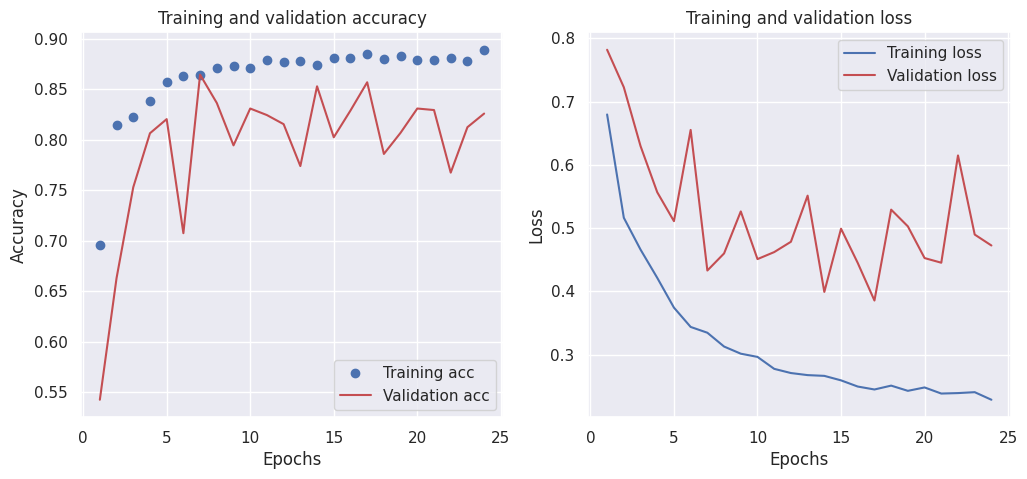

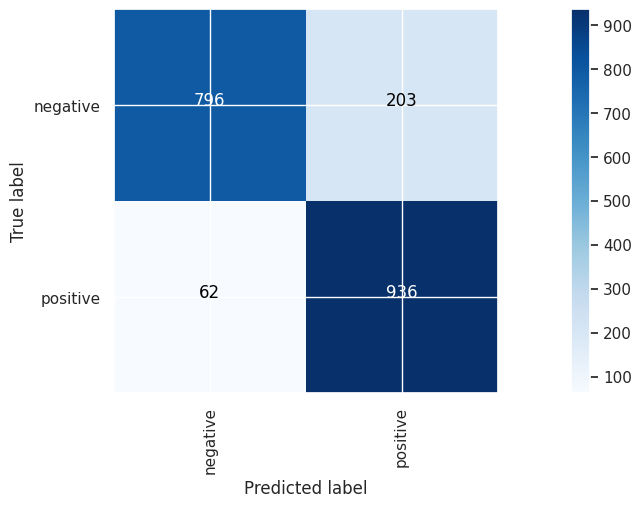

Final Accuracy
0.8673009514271407
Model: "Exp07LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 600)]             0         
                                                                 
 embedding_20 (Embedding)    (None, 600, 50)           1488650   
                                                                 
 bidirectional_9 (Bidirecti  (None, 2)                 416       
 onal)                                                           
                                                                 
 dropout_14 (Dropout)        (None, 2)                 0         
                                                                 
 dense_20 (Dense)            (None, 2)                 6         
                                                                 
Total params: 1489072 (5.68 MB)
Trainable params: 1489072 (5.68 MB)
Non-trainable params:

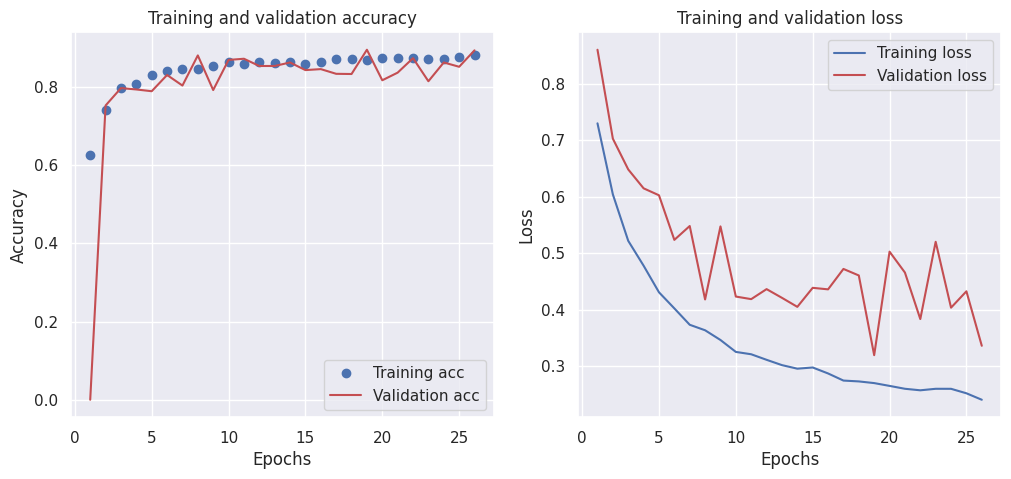

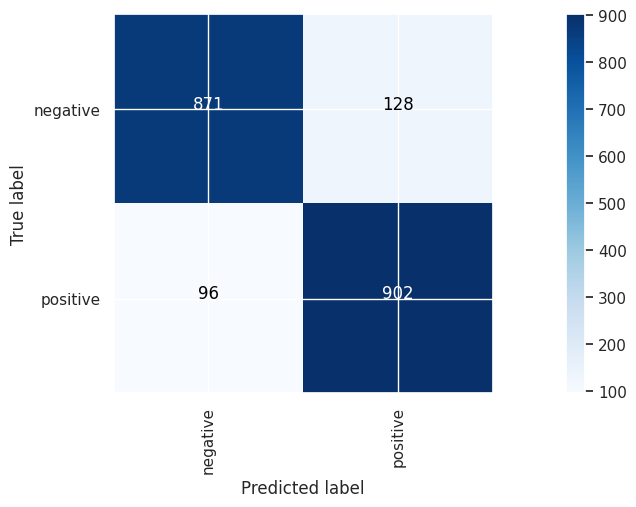

Final Accuracy
0.8878317476214321


In [19]:
results = []
name = "LSTM"
description =   """
                layers_units=[1],
                extra_dense_layer_nn=0,
                extra_dense_dropout=0.0,
                dropout_layer=0.3,
                dropout=[0.25],
                recurrent_dropout=[0.0],
                make_it_bidirectional=True,
                kernel_regularizer=regularizers.l2(0.01)
                """
description = description.replace('\t', '').replace('\n', '').replace(' ', '')

layers_units=[1]
extra_dense_layer_nn=0
extra_dense_dropout=0.0
dropout_layer=0.3
dropout=[0.25]
recurrent_dropout=[0.0]
make_it_bidirectional=True
kernel_regularizer=kernel_regularizer=regularizers.l2(0.01)

# Embedding with padding
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp07(name,
            description, 
            embedding_padding, 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout=extra_dense_dropout,
            dropout_layer=dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer          
            )

# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp07(name,
            description, 
            embedding_glove, 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout=extra_dense_dropout,
            dropout_layer=dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer       
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_07_10.csv", index=False)

Model: "Exp07LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 600)]             0         
                                                                 
 embedding_21 (Embedding)    (None, 600, 50)           1488650   
                                                                 
 bidirectional_10 (Bidirect  (None, 2)                 416       
 ional)                                                          
                                                                 
 dropout_15 (Dropout)        (None, 2)                 0         
                                                                 
 dense_21 (Dense)            (None, 2)                 6         
                                                                 
Total params: 1489072 (5.68 MB)
Trainable params: 1489072 (5.68 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

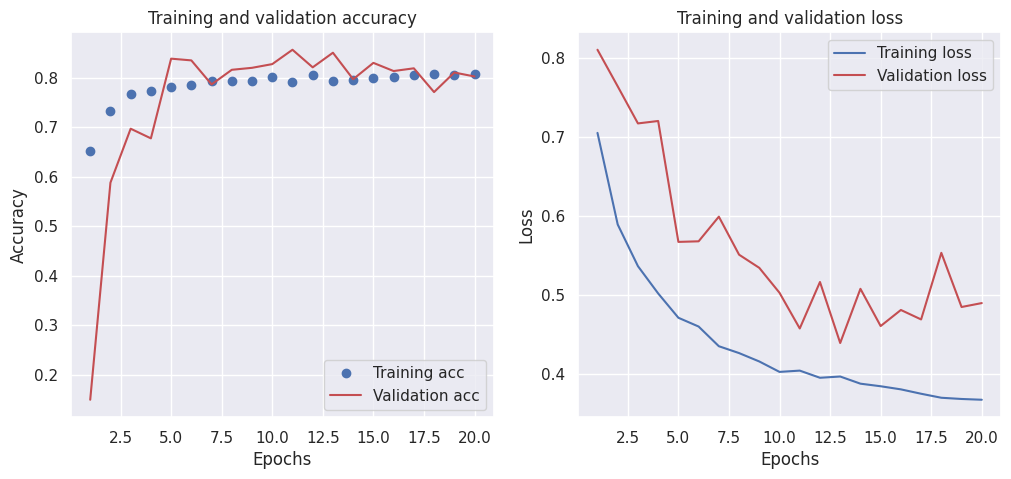

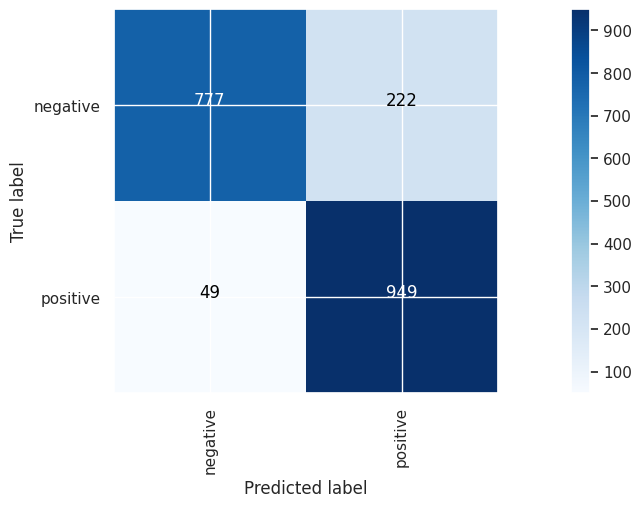

Final Accuracy
0.8642964446670005
Model: "Exp07LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 600)]             0         
                                                                 
 embedding_22 (Embedding)    (None, 600, 50)           1488650   
                                                                 
 bidirectional_11 (Bidirect  (None, 2)                 416       
 ional)                                                          
                                                                 
 dropout_16 (Dropout)        (None, 2)                 0         
                                                                 
 dense_22 (Dense)            (None, 2)                 6         
                                                                 
Total params: 1489072 (5.68 MB)
Trainable params: 1489072 (5.68 MB)
Non-trainable params:

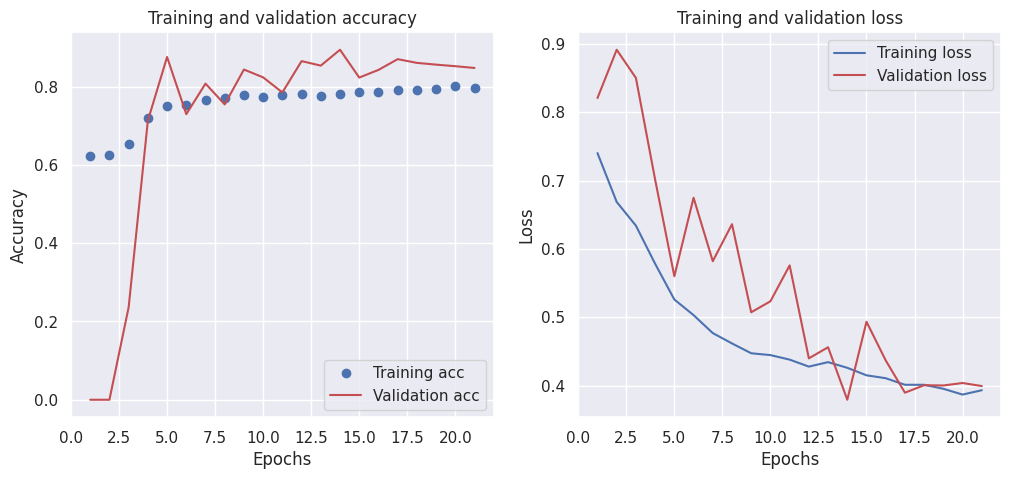

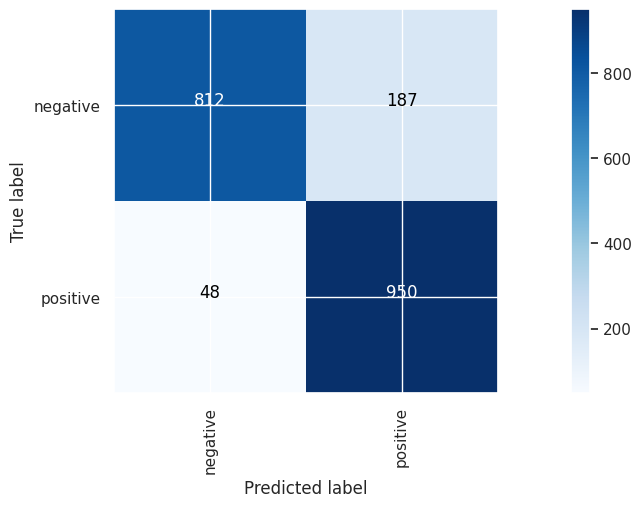

Final Accuracy
0.8823234852278418


In [20]:
results = []
name = "LSTM"
description =   """
                layers_units=[1],
                extra_dense_layer_nn=0,
                extra_dense_dropout=0.0,
                dropout_layer=0.5,
                dropout=[0.5],
                recurrent_dropout=[0.0],
                make_it_bidirectional=True,
                kernel_regularizer=regularizers.l2(0.01)
                """
description = description.replace('\t', '').replace('\n', '').replace(' ', '')

layers_units=[1]
extra_dense_layer_nn=0
extra_dense_dropout=0.0
dropout_layer=0.5
dropout=[0.5]
recurrent_dropout=[0.0]
make_it_bidirectional=True
kernel_regularizer=kernel_regularizer=regularizers.l2(0.01)

# Embedding with padding
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp07(name,
            description, 
            embedding_padding, 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout=extra_dense_dropout,
            dropout_layer=dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer          
            )

# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp07(name,
            description, 
            embedding_glove, 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout=extra_dense_dropout,
            dropout_layer=dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer       
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_07_11.csv", index=False)

Model: "Exp07LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 600)]             0         
                                                                 
 embedding_23 (Embedding)    (None, 600, 50)           1488650   
                                                                 
 bidirectional_12 (Bidirect  (None, 2)                 416       
 ional)                                                          
                                                                 
 dropout_17 (Dropout)        (None, 2)                 0         
                                                                 
 dense_23 (Dense)            (None, 2)                 6         
                                                                 
Total params: 1489072 (5.68 MB)
Trainable params: 1489072 (5.68 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

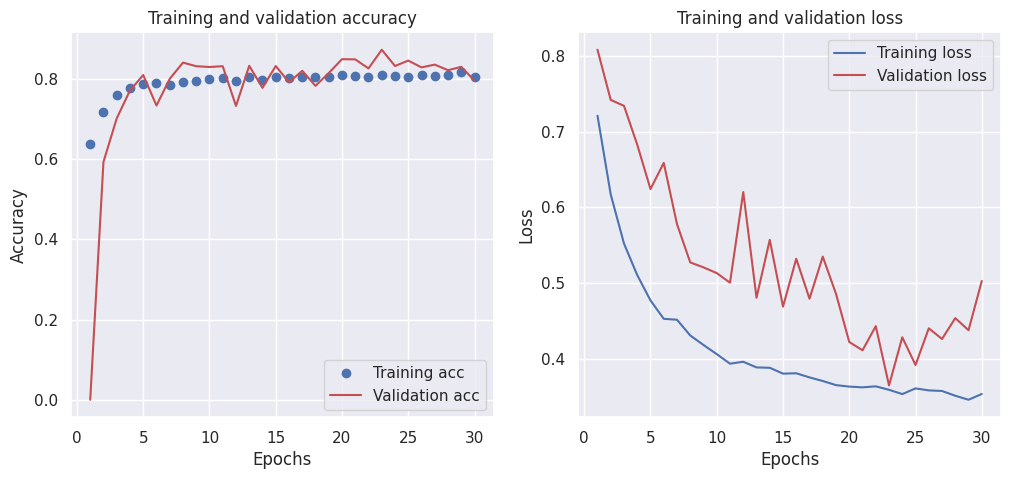

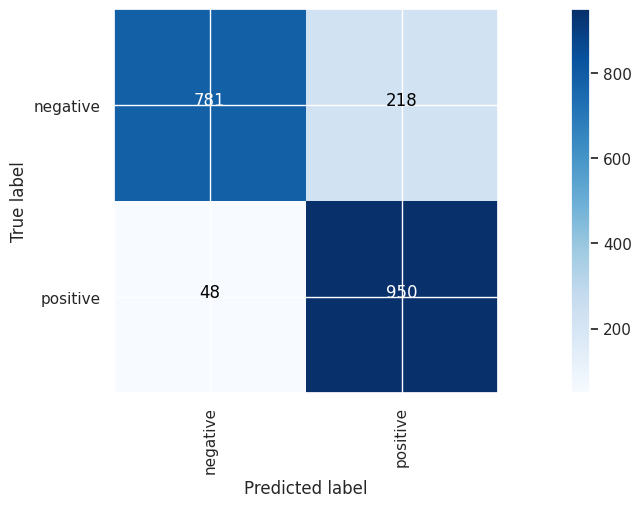

Final Accuracy
0.8668002003004507
Model: "Exp07LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 600)]             0         
                                                                 
 embedding_24 (Embedding)    (None, 600, 50)           1488650   
                                                                 
 bidirectional_13 (Bidirect  (None, 2)                 416       
 ional)                                                          
                                                                 
 dropout_18 (Dropout)        (None, 2)                 0         
                                                                 
 dense_24 (Dense)            (None, 2)                 6         
                                                                 
Total params: 1489072 (5.68 MB)
Trainable params: 1489072 (5.68 MB)
Non-trainable params:

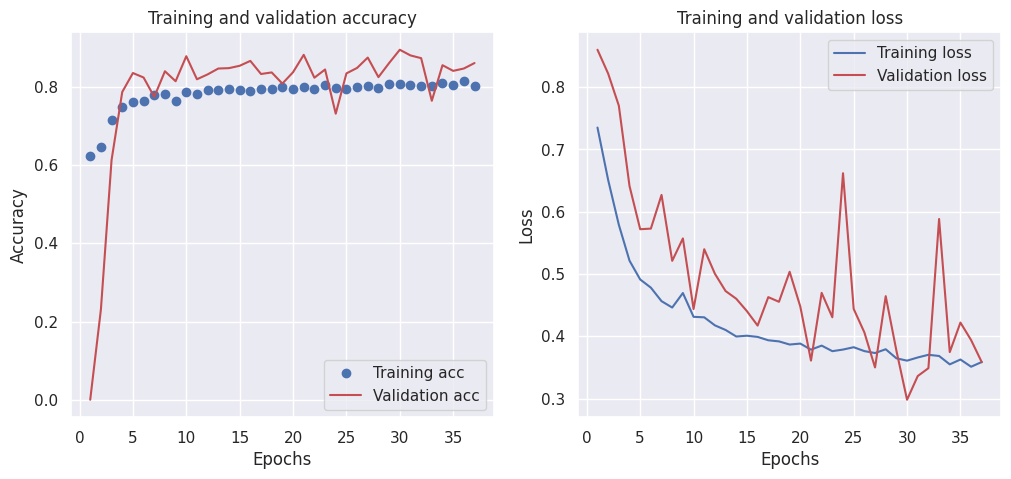

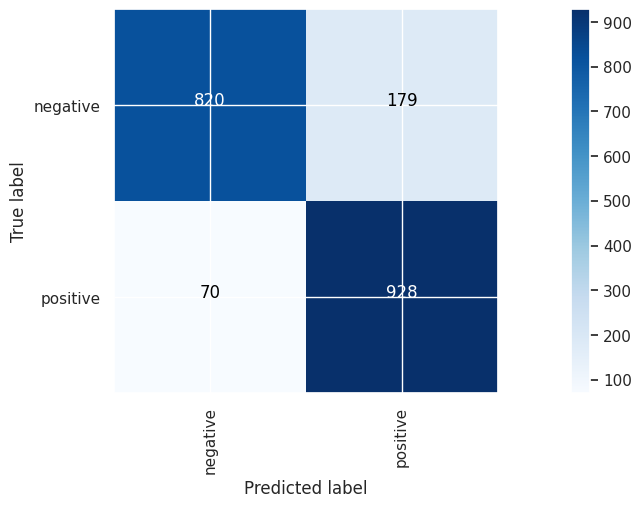

Final Accuracy
0.8753129694541812


In [21]:
results = []
name = "LSTM"
description =   """
                layers_units=[1],
                extra_dense_layer_nn=0,
                extra_dense_dropout=0.0,
                dropout_layer=0.5,
                dropout=[0.5],
                recurrent_dropout=[0.0],
                make_it_bidirectional=True,
                kernel_regularizer=regularizers.l2(0.01)
                """
description = description.replace('\t', '').replace('\n', '').replace(' ', '')

layers_units=[1]
extra_dense_layer_nn=0
extra_dense_dropout=0.0
dropout_layer=0.5
dropout=[0.3]
recurrent_dropout=[0.0]
make_it_bidirectional=True
kernel_regularizer=kernel_regularizer=regularizers.l2(0.01)

# Embedding with padding
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp07(name,
            description, 
            embedding_padding, 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout=extra_dense_dropout,
            dropout_layer=dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer          
            )

# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp07(name,
            description, 
            embedding_glove, 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout=extra_dense_dropout,
            dropout_layer=dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer       
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_07_12.csv", index=False)

Model: "Exp07LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 600)]             0         
                                                                 
 embedding_25 (Embedding)    (None, 600, 50)           1488650   
                                                                 
 bidirectional_14 (Bidirect  (None, 2)                 416       
 ional)                                                          
                                                                 
 dropout_19 (Dropout)        (None, 2)                 0         
                                                                 
 dense_25 (Dense)            (None, 64)                192       
                                                                 
 dropout_20 (Dropout)        (None, 64)                0         
                                                         

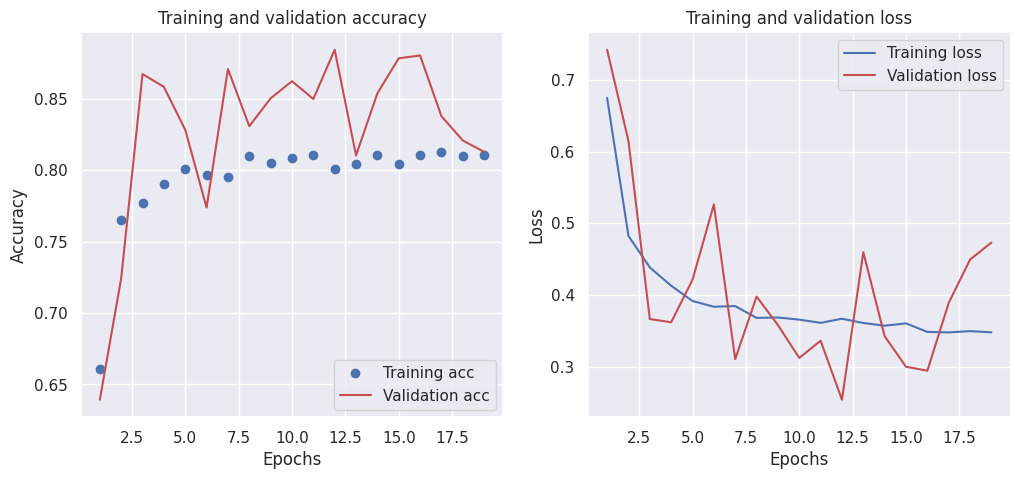

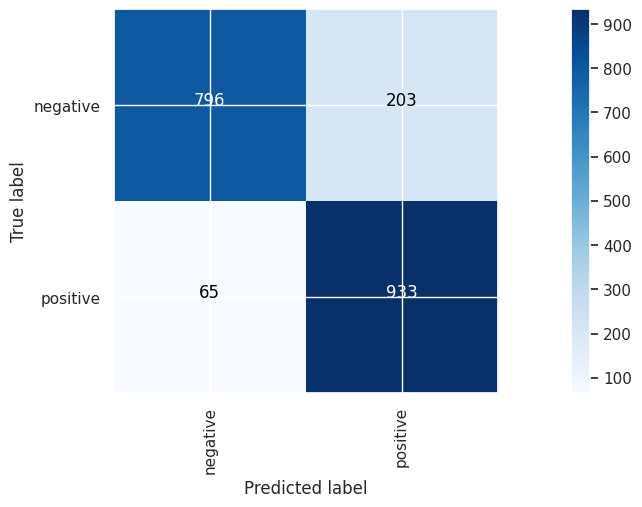

Final Accuracy
0.8657986980470707
Model: "Exp07LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 600)]             0         
                                                                 
 embedding_26 (Embedding)    (None, 600, 50)           1488650   
                                                                 
 bidirectional_15 (Bidirect  (None, 2)                 416       
 ional)                                                          
                                                                 
 dropout_21 (Dropout)        (None, 2)                 0         
                                                                 
 dense_27 (Dense)            (None, 64)                192       
                                                                 
 dropout_22 (Dropout)        (None, 64)                0         
                       

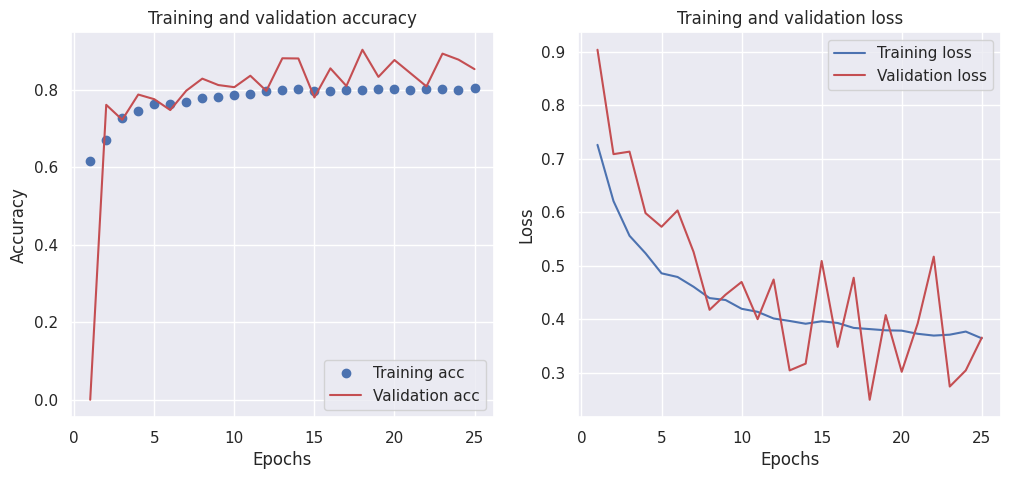

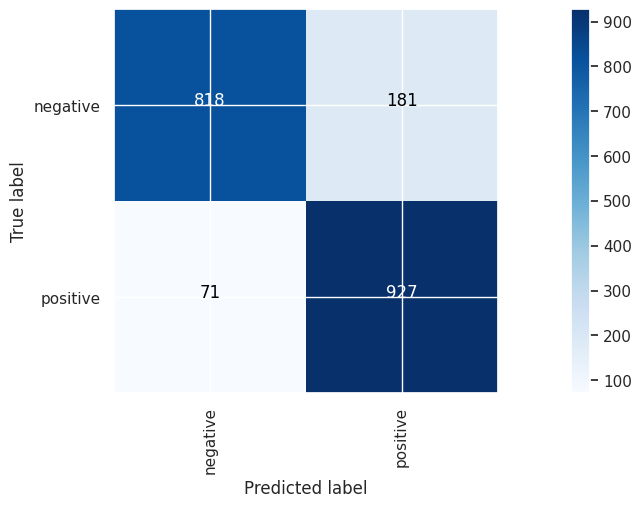

Final Accuracy
0.8738107160741112


In [22]:
results = []
name = "LSTM"
description =   """
                layers_units=[1],
                extra_dense_layer_nn=64,
                extra_dense_dropout=0.5,
                dropout_layer=0.5,
                dropout=[0.3],
                recurrent_dropout=[0.0],
                make_it_bidirectional=True,
                kernel_regularizer=regularizers.l2(0.01)
                """
description = description.replace('\t', '').replace('\n', '').replace(' ', '')

layers_units=[1]
extra_dense_layer_nn=64
extra_dense_dropout=0.5
dropout_layer=0.5
dropout=[0.2]
recurrent_dropout=[0.0]
make_it_bidirectional=True
kernel_regularizer=kernel_regularizer=regularizers.l2(0.01)

# Embedding with padding
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp07(name,
            description, 
            embedding_padding, 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout=extra_dense_dropout,
            dropout_layer=dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer          
            )

# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp07(name,
            description, 
            embedding_glove, 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout=extra_dense_dropout,
            dropout_layer=dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer       
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_07_13.csv", index=False)

Model: "Exp07LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 600)]             0         
                                                                 
 embedding_27 (Embedding)    (None, 600, 50)           1488650   
                                                                 
 bidirectional_16 (Bidirect  (None, 4)                 848       
 ional)                                                          
                                                                 
 dropout_23 (Dropout)        (None, 4)                 0         
                                                                 
 dense_29 (Dense)            (None, 64)                320       
                                                                 
 dropout_24 (Dropout)        (None, 64)                0         
                                                         

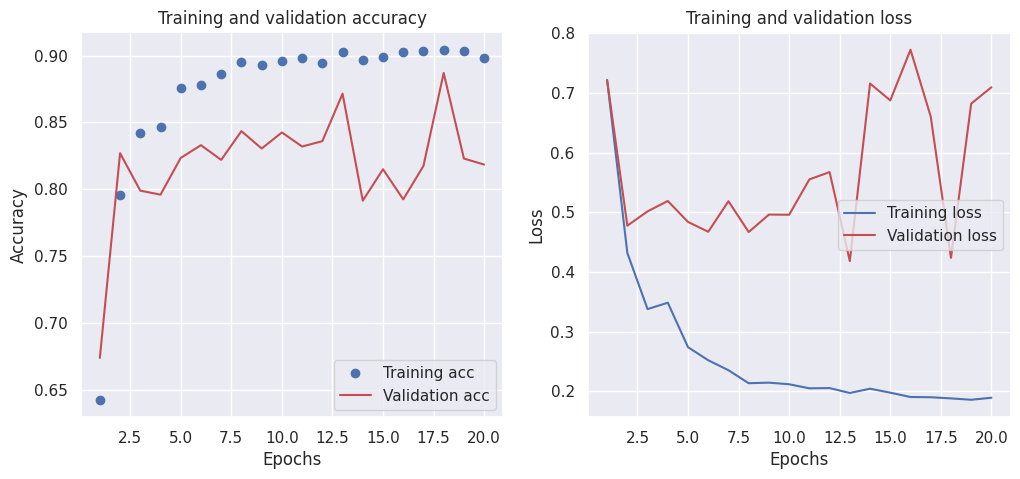

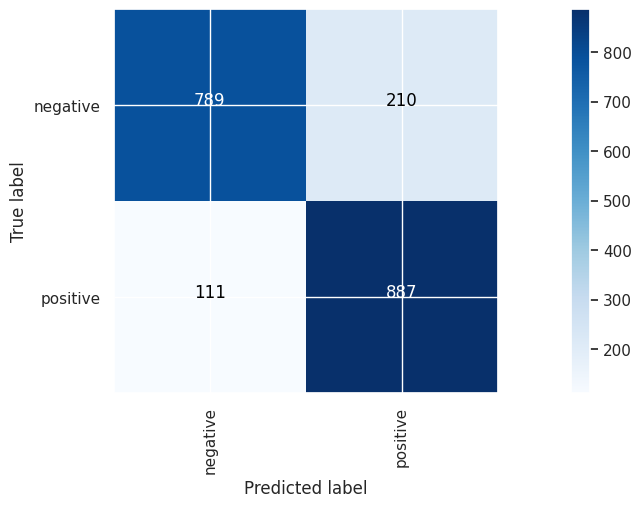

Final Accuracy
0.8392588883324987
Model: "Exp07LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 600)]             0         
                                                                 
 embedding_28 (Embedding)    (None, 600, 50)           1488650   
                                                                 
 bidirectional_17 (Bidirect  (None, 4)                 848       
 ional)                                                          
                                                                 
 dropout_25 (Dropout)        (None, 4)                 0         
                                                                 
 dense_31 (Dense)            (None, 64)                320       
                                                                 
 dropout_26 (Dropout)        (None, 64)                0         
                       

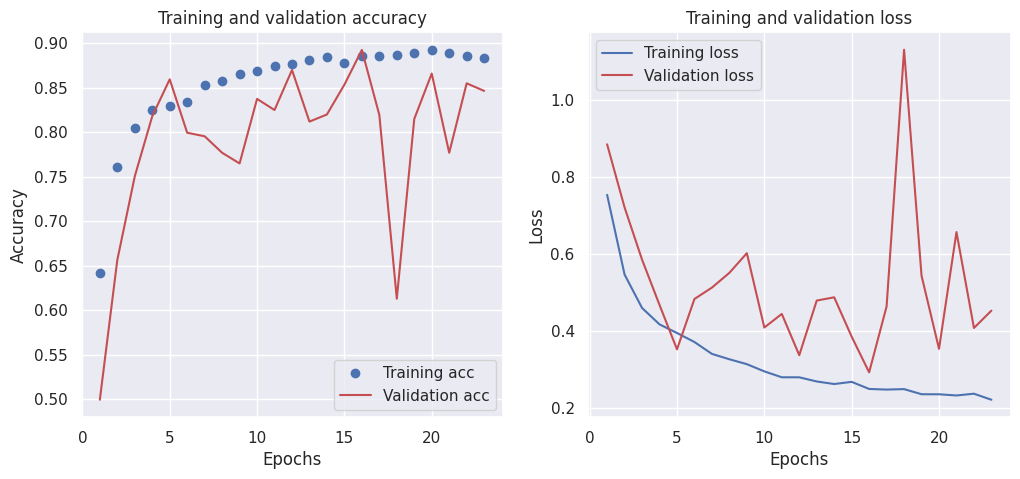

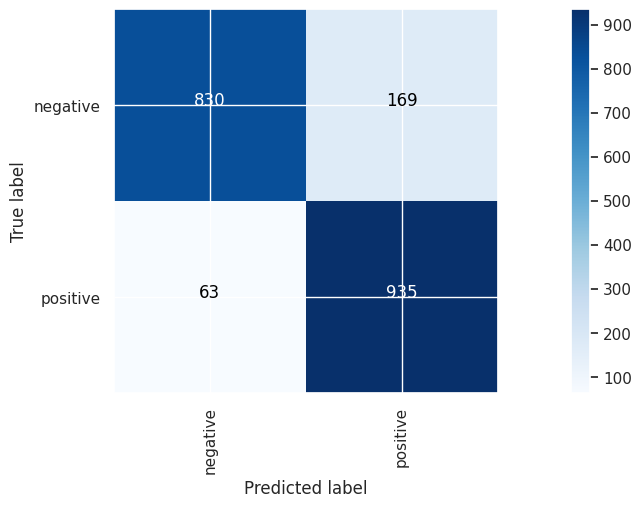

Final Accuracy
0.8838257386079119


In [23]:
results = []
name = "LSTM"
description =   """
                layers_units=[2],
                extra_dense_layer_nn=64,
                extra_dense_dropout=0.5,
                dropout_layer=0.5,
                dropout=[0.4],
                recurrent_dropout=[0.0],
                make_it_bidirectional=True,
                kernel_regularizer=regularizers.l2(0.01)
                """
description = description.replace('\t', '').replace('\n', '').replace(' ', '')

layers_units=[2]
extra_dense_layer_nn=64
extra_dense_dropout=0.5
dropout_layer=0.5
dropout=[0.3]
recurrent_dropout=[0.0]
make_it_bidirectional=True
kernel_regularizer=kernel_regularizer=regularizers.l2(0.01)

# Embedding with padding
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp07(name,
            description, 
            embedding_padding, 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout=extra_dense_dropout,
            dropout_layer=dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer          
            )

# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp07(name,
            description, 
            embedding_glove, 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout=extra_dense_dropout,
            dropout_layer=dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer       
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_07_14.csv", index=False)

2024-04-28 22:42:13.259452: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-28 22:42:13.380600: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-28 22:42:13.380812: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "Exp07LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 600)]             0         
                                                                 
 embedding (Embedding)       (None, 600, 50)           1488650   
                                                                 
 bidirectional (Bidirection  (None, 16)                3776      
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 64)                1088      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                         

2024-04-28 22:42:16.364595: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-28 22:42:16.695486: I external/local_xla/xla/service/service.cc:168] XLA service 0x7e3876726df0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-28 22:42:16.695514: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-04-28 22:42:16.703211: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1714336936.767201  901908 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 [==============================] - 35s 130ms/step - loss: 0.8034 - accuracy: 0.7117 - val_loss: 0.4185 - val_accuracy: 0.8419
Epoch 2/40
250/250 [==============================] - 26s 104ms/step - loss: 0.2470 - accuracy: 0.9202 - val_loss: 0.4106 - val_accuracy: 0.8434
Epoch 3/40
250/250 [==============================] - 23s 91ms/step - loss: 0.1439 - accuracy: 0.9611 - val_loss: 0.5527 - val_accuracy: 0.8019
Epoch 4/40
250/250 [==============================] - 20s 82ms/step - loss: 0.1008 - accuracy: 0.9742 - val_loss: 0.3978 - val_accuracy: 0.8709
Epoch 5/40
250/250 [==============================] - 20s 78ms/step - loss: 0.0761 - accuracy: 0.9827 - val_loss: 0.8815 - val_accuracy: 0.8044
Epoch 6/40
250/250 [==============================] - 17s 67ms/step - loss: 0.0713 - accuracy: 0.9856 - val_loss: 0.5110 - val_accuracy: 0.8444
Epoch 7/40
250/250 [==============================] - 16s 63ms/step - loss: 0.0562 - accuracy: 0.9874 - val_loss: 0.8596 - val_accuracy: 0.8059
E

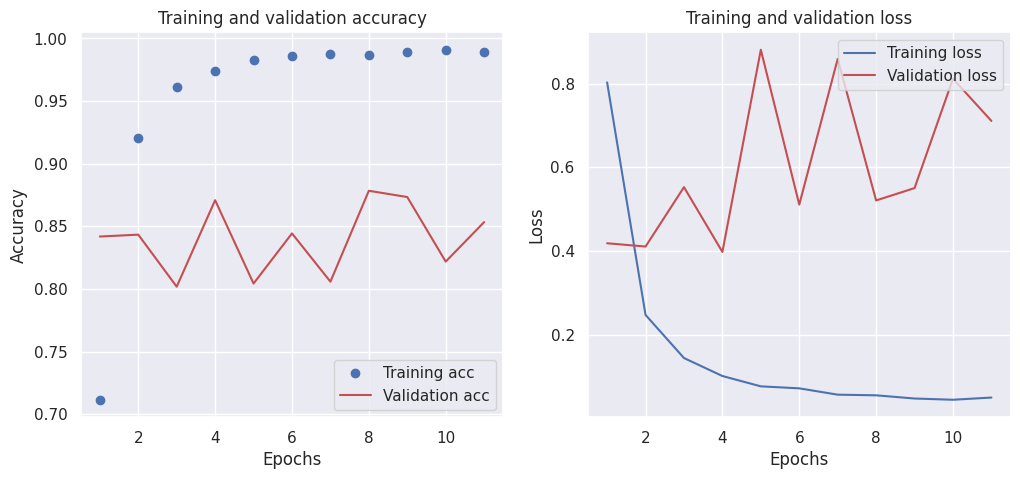

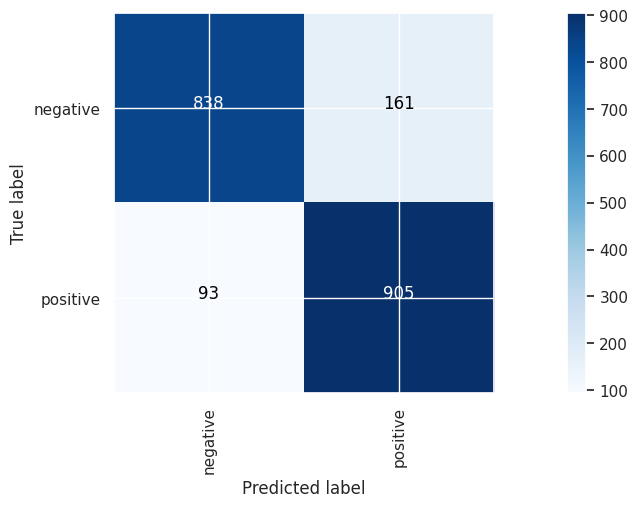

Final Accuracy
0.8728092138207311
Model: "Exp07LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 600)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 600, 50)           1488650   
                                                                 
 bidirectional_1 (Bidirecti  (None, 16)                3776      
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                1088      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                       

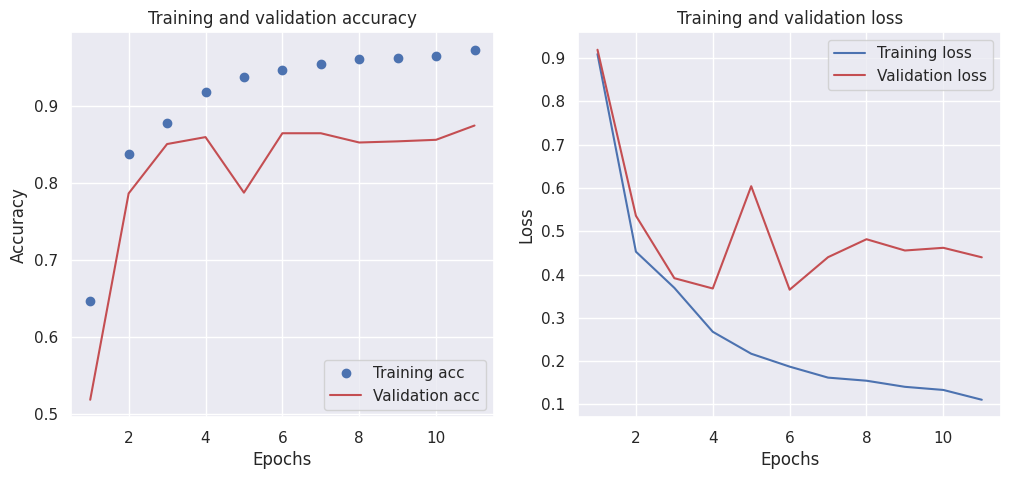

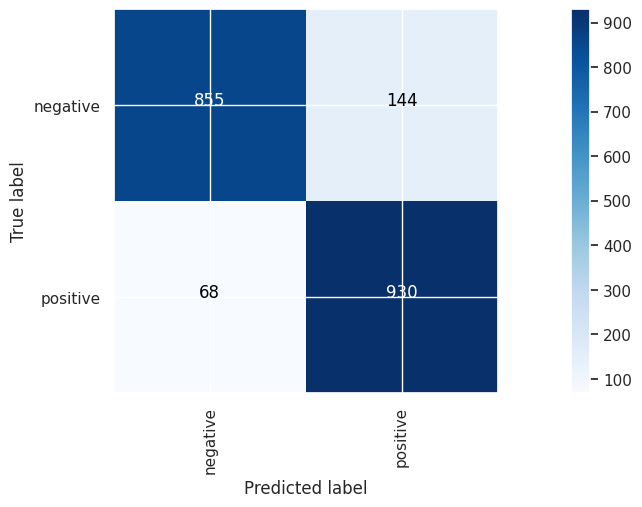

Final Accuracy
0.8938407611417125


In [8]:
results = []
name = "LSTM"
description =   """
                layers_units=[8],
                extra_dense_layer_nn=64,
                extra_dense_dropout=0.5,
                dropout_layer=0.4,
                dropout=[0.25],
                recurrent_dropout=[0.0],
                make_it_bidirectional=True,
                kernel_regularizer=regularizers.l2(0.01)
                """
description = description.replace('\t', '').replace('\n', '').replace(' ', '')

layers_units=[8]
extra_dense_layer_nn=64
extra_dense_dropout=0.5
dropout_layer=0.4
dropout=[0.25]
recurrent_dropout=[0.0]
make_it_bidirectional=True
kernel_regularizer=kernel_regularizer=regularizers.l2(0.01)

# Embedding with padding
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp07(name,
            description, 
            embedding_padding, 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout=extra_dense_dropout,
            dropout_layer=dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer          
            )

# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp07(name,
            description, 
            embedding_glove, 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout=extra_dense_dropout,
            dropout_layer=dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            make_it_bidirectional=make_it_bidirectional,
            kernel_regularizer=kernel_regularizer       
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_07_15.csv", index=False)

2024-04-29 09:45:36.872158: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-29 09:45:36.991288: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-29 09:45:36.991520: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "Exp07LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5000, 1)]         0         
                                                                 
 bidirectional (Bidirection  (None, 16)                640       
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 64)                1088      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                         

2024-04-29 09:45:40.187234: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-29 09:45:40.642960: I external/local_xla/xla/service/service.cc:168] XLA service 0x7572407e9e40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-29 09:45:40.642988: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-04-29 09:45:40.650681: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1714376740.715361    6537 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 [==============================] - 74s 284ms/step - loss: 0.6812 - accuracy: 0.6208 - val_loss: 0.9055 - val_accuracy: 0.0385
Epoch 2/40
250/250 [==============================] - 72s 288ms/step - loss: 0.6518 - accuracy: 0.6347 - val_loss: 0.9204 - val_accuracy: 0.1226
Epoch 3/40
250/250 [==============================] - 73s 291ms/step - loss: 0.6316 - accuracy: 0.6586 - val_loss: 0.8434 - val_accuracy: 0.3442
Epoch 4/40
250/250 [==============================] - 72s 289ms/step - loss: 0.6166 - accuracy: 0.6739 - val_loss: 0.7688 - val_accuracy: 0.5053
Epoch 5/40
250/250 [==============================] - 72s 289ms/step - loss: 0.5867 - accuracy: 0.7044 - val_loss: 0.7639 - val_accuracy: 0.5413
Epoch 6/40
250/250 [==============================] - 71s 284ms/step - loss: 0.5806 - accuracy: 0.7050 - val_loss: 0.7311 - val_accuracy: 0.5793
Epoch 7/40
250/250 [==============================] - 71s 284ms/step - loss: 0.5729 - accuracy: 0.7104 - val_loss: 0.7086 - val_accuracy: 0.6

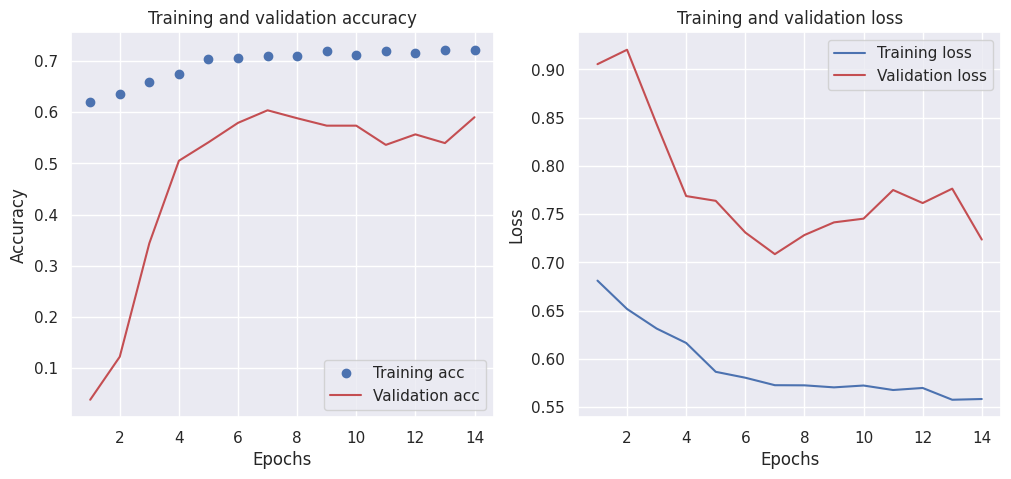

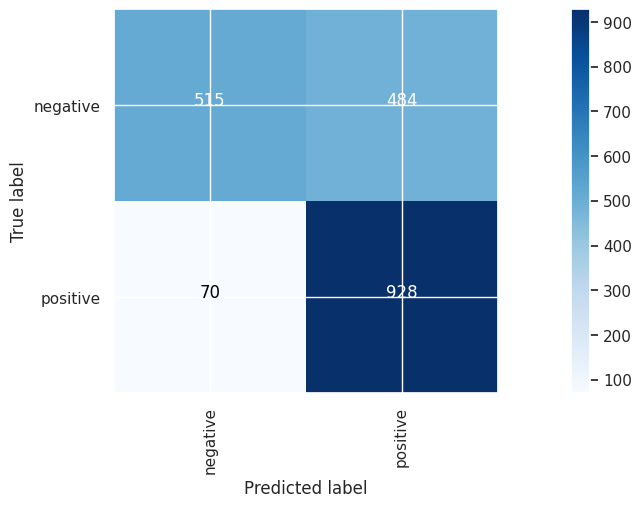

Final Accuracy
0.7225838758137206
Model: "Exp07LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5000, 1)]         0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 16)                640       
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                1088      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                       

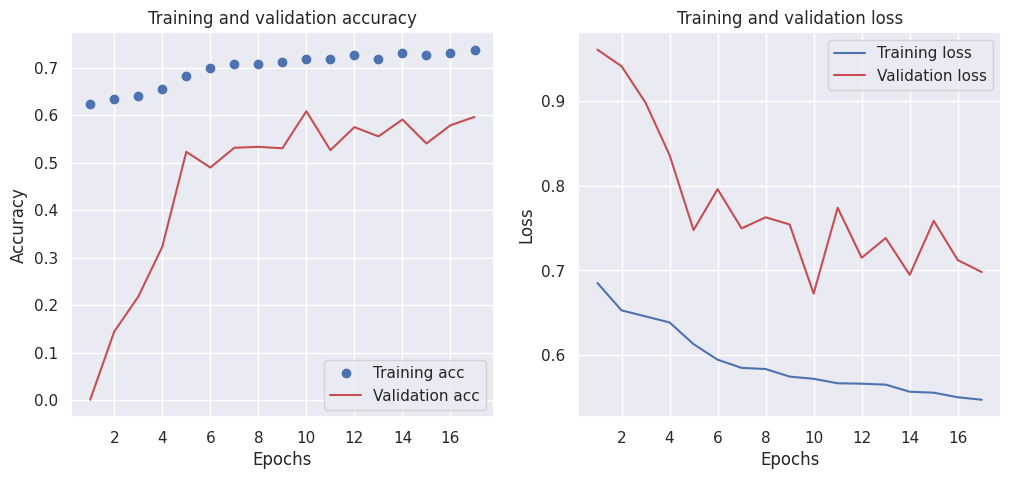

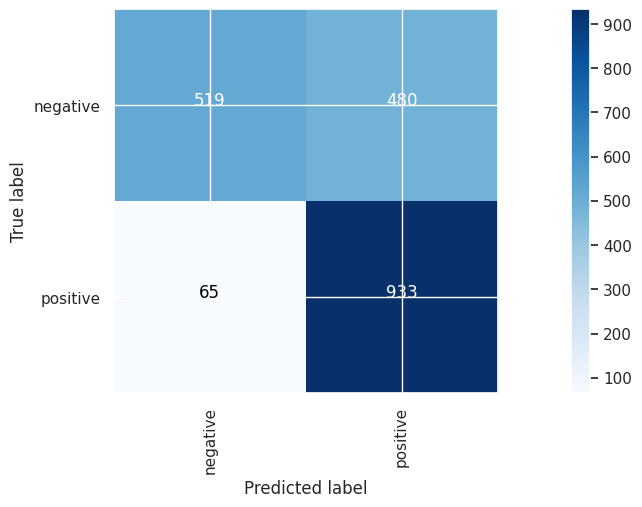

Final Accuracy
0.7270906359539309
Model: "Exp07LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 5000, 1)]         0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 16)                640       
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 64)                1088      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 2)                 130       
                       

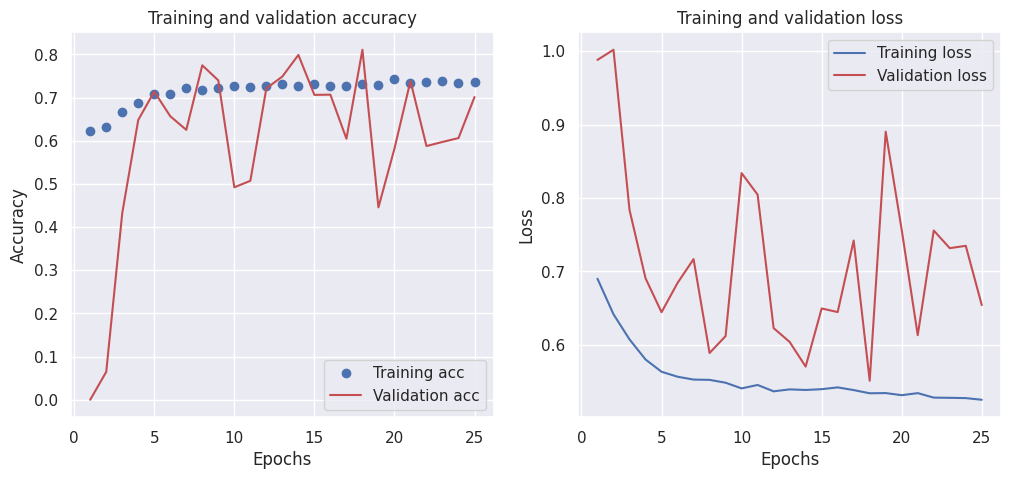

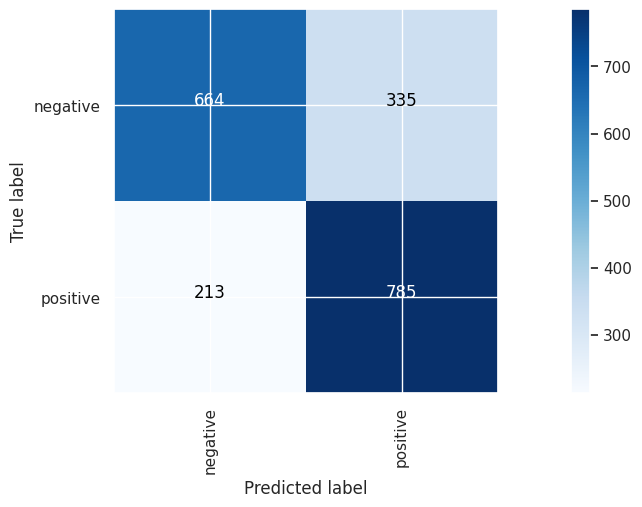

Final Accuracy
0.7255883825738608
Model: "Exp07LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 5000, 1)]         0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 16)                640       
 onal)                                                           
                                                                 
 dropout_6 (Dropout)         (None, 16)                0         
                                                                 
 dense_6 (Dense)             (None, 64)                1088      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 2)                 130       
                       

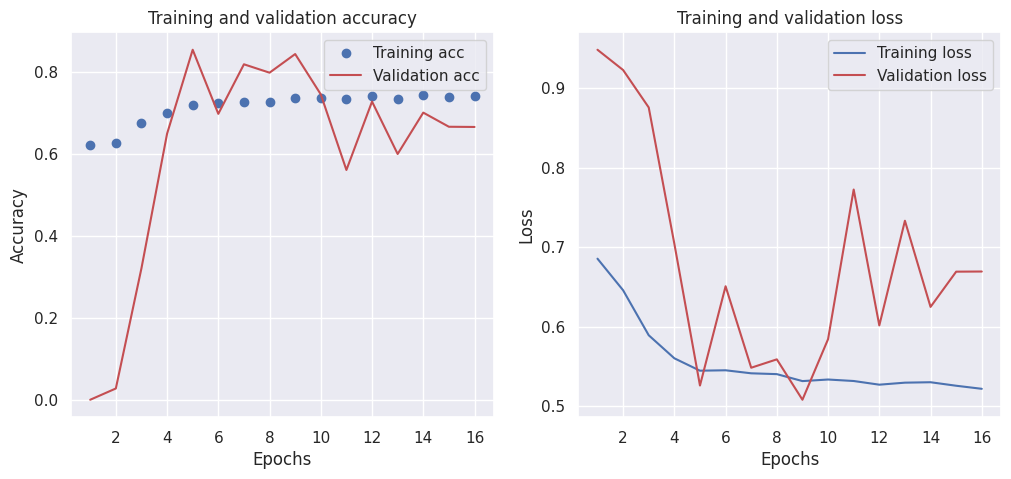

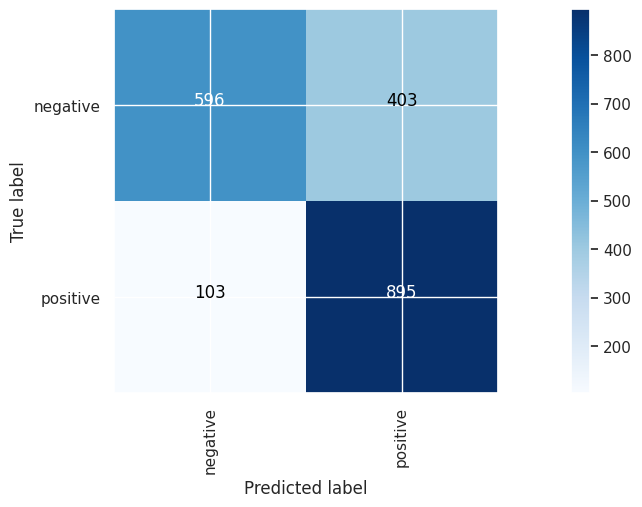

Final Accuracy
0.7466199298948423


In [7]:
results = []
name = "LSTM"
description =   """
                layers_units=[8],
                extra_dense_layer_nn=64,
                extra_dense_dropout=0.5,
                dropout_layer=0.4,
                dropout=[0.15],
                recurrent_dropout=[0.0],
                make_it_bidirectional=True,
                kernel_regularizer=regularizers.l2(0.01)
                """
description = description.replace('\t', '').replace('\n', '').replace(' ', '')

layers_units=[8]
extra_dense_layer_nn=64
extra_dense_dropout=0.5
dropout_layer=0.4
dropout=[0.15]
recurrent_dropout=[0.0]
make_it_bidirectional=True
kernel_regularizer=kernel_regularizer=regularizers.l2(0.01)

# VSM models
results = []
for rep in vsm_model:
    build_exp07(name,
                description, 
                rep, 
                input_shape=(5000,1,),
                layers_units=layers_units,
                extra_dense_layer_nn=extra_dense_layer_nn,
                extra_dense_dropout=extra_dense_dropout,
                dropout_layer=dropout_layer,
                dropout=dropout,
                recurrent_dropout=recurrent_dropout,
                make_it_bidirectional=make_it_bidirectional,
                kernel_regularizer=kernel_regularizer 
                )

partial = pd.DataFrame(results)
partial.to_csv("exp_07_16.csv", index=False)

## Conclusiones

In [8]:
join_csv_for_experiment("07", 16)
pd.read_csv("exp_07.csv").sort_values(by=["accuracy"], ascending=False, ignore_index=True)[["classifier", "rep.model", "accuracy","precision","recall"]]

classifier  \
0                   Exp07LSTM layers_units=[16,32],extra_dense_layer_nn=0,extra_dense_dropout=0.0,dropout_layer=0.5,dropout=[0.5,0.5],recurrent_dropout=[0.0,0.0],make_it_bidirectional=False,kernel_regularizer=None   
1              Exp07LSTM layers_units=[16],extra_dense_layer_nn=0,extra_dense_dropout=0.0,dropout_layer=0.5,dropout=[0.5],recurrent_dropout=[0.0],make_it_bidirectional=True,kernel_regularizer=regularizers.l2(0.01)   
2             Exp07LSTM layers_units=[8],extra_dense_layer_nn=64,extra_dense_dropout=0.5,dropout_layer=0.4,dropout=[0.25],recurrent_dropout=[0.0],make_it_bidirectional=True,kernel_regularizer=regularizers.l2(0.01)   
3   Exp07LSTM layers_units=[16,32],extra_dense_layer_nn=0,extra_dense_dropout=0.0,dropout_layer=0.5,dropout=[0.5,0.5],recurrent_dropout=[0.0,0.0],make_it_bidirectional=True,kernel_regularizer=regularizers.l2(0.01)   
4                   Exp07LSTM layers_units=[16,32],extra_dense_layer_nn=0,extra_dense_dropout=0.0,dropout_layer=0.2,dropout=[0.4,0.4],recurrent_dropout=[0.0,0.0],make_it_bidirectional=False,kernel_regularizer=None   
5              Exp07LSTM layers_units=[1],extra_dense_layer_nn=0,extra_dense_dropout=0.0,dropout_layer=0.3,dropout=[0.25],recurrent_dropout=[0.0],make_it_bidirectional=True,kernel_regularizer=regularizers.l2(0.01)   
6              Exp07LSTM layers_units=[2],extra_dense_layer_nn=64,extra_dense_dropout=0.5,dropout_layer=0.5,dropout=[0.4],recurrent_dropout=[0.0],make_it_bidirectional=True,kernel_regularizer=regularizers.l2(0.01)   
7              Exp07LSTM layers_units=[16],extra_dense_layer_nn=0,extra_dense_dropout=0.0,dropout_layer=0.5,dropout=[0.5],recurrent_dropout=[0.0],make_it_bidirectional=True,kernel_regularizer=regularizers.l2(0.01)   
8               Exp07LSTM layers_units=[1],extra_dense_layer_nn=0,extra_dense_dropout=0.0,dropout_layer=0.5,dropout=[0.5],recurrent_dropout=[0.0],make_it_bidirectional=True,kernel_regularizer=regularizers.l2(0.01)   
9             Exp07LSTM layers_units=[16],extra_dense_layer_nn=0,extra_dense_dropout=0.0,dropout_layer=0.0,dropout=[0.0],recurrent_dropout=[0.0],make_it_bidirectional=False,kernel_regularizer=regularizers.l2(0.01)   
10            Exp07LSTM layers_units=[1],extra_dense_layer_nn=0,extra_dense_dropout=0.0,dropout_layer=0.3,dropout=[0.25],recurrent_dropout=[0.0],make_it_bidirectional=False,kernel_regularizer=regularizers.l2(0.01)   
11              Exp07LSTM layers_units=[1],extra_dense_layer_nn=0,extra_dense_dropout=0.0,dropout_layer=0.5,dropout=[0.5],recurrent_dropout=[0.0],make_it_bidirectional=True,kernel_regularizer=regularizers.l2(0.01)   
12            Exp07LSTM layers_units=[16],extra_dense_layer_nn=0,extra_dense_dropout=0.0,dropout_layer=0.0,dropout=[0.0],recurrent_dropout=[0.0],make_it_bidirectional=False,kernel_regularizer=regularizers.l2(0.01)   
13             Exp07LSTM layers_units=[1],extra_dense_layer_nn=64,extra_dense_dropout=0.5,dropout_layer=0.5,dropout=[0.3],recurrent_dropout=[0.0],make_it_bidirectional=True,kernel_regularizer=regularizers.l2(0.01)   
14            Exp07LSTM layers_units=[8],extra_dense_layer_nn=64,extra_dense_dropout=0.5,dropout_layer=0.4,dropout=[0.25],recurrent_dropout=[0.0],make_it_bidirectional=True,kernel_regularizer=regularizers.l2(0.01)   
15                  Exp07LSTM layers_units=[16,32],extra_dense_layer_nn=0,extra_dense_dropout=0.0,dropout_layer=0.5,dropout=[0.2,0.2],recurrent_dropout=[0.0,0.0],make_it_bidirectional=False,kernel_regularizer=None   
16             Exp07LSTM layers_units=[16],extra_dense_layer_nn=0,extra_dense_dropout=0.0,dropout_layer=0.0,dropout=[0.0],recurrent_dropout=[0.0],make_it_bidirectional=True,kernel_regularizer=regularizers.l2(0.01)   
17             Exp07LSTM layers_units=[1],extra_dense_layer_nn=0,extra_dense_dropout=0.0,dropout_layer=0.3,dropout=[0.25],recurrent_dropout=[0.0],make_it_bidirectional=True,kernel_regularizer=regularizers.l2(0.01)   
18                  Exp07LSTM layers_units=[16,32],extra_dense_layer_nn=0,extra_